Aluksi esitellään funktiot
Niiden tehtävänä on lukea tai auttaa lukemaan dataa eri lähteistä


# Apufunktiot

In [1]:
def add_zeros(element):
    #postinumeroihin etunollat jos on ollut integer
    element=str(element)
    if len(element) == 3:
        element = "00" + element
    if len(element) == 4:
        element = "0" + element
    return(element)

In [2]:
def add_zeros_muncipality(element):
    #postinumeroihin etunollat jos on ollut integer
    element=str(element)
    if len(element) == 1:
        element = "00" + element
    if len(element) == 2:
        element = "0" + element
    return(element)



In [3]:
def read_post():

    #luetaan postilta viimeisimmät tiedot postinumeroista
    #ja haetaan siihen lisäksi tilastokeskukselta polygonit
    
    import pandas as pd
    import geopandas as gp
    from urllib.request import urlopen
    import requests 
    import re
    import zipfile
    import os
    import io
    import geopandas as gp
    import numpy as np


    # http://www.posti.fi/liitteet-yrityksille/ehdot/postinumeropalvelut-palvelukuvaus-ja-kayttoehdot.pdf

    index = urlopen("http://www.posti.fi/webpcode/unzip/").read().decode('utf-8')

    # Find the DAT file (latest)
    postcodes_filename = re.findall(r'http://www.posti.fi/webpcode/unzip/PCF_[0-9]*?\.dat', index)[0]

    # Example of the name
    #postcodes_filename = ('https://www.posti.fi/webpcode/unzip/PCF_20200325.dat')

    # Manage data
    #from postcode two extra chars included
    headings = ['postcode', 'postcode_name', 'postcode_sv_name', 'type', 'area_code', 'area_name', 'muncipality_code', 'muncipality_name', 'muncipality_sv_name', 'language_code']
    colspecs = [(13, 18), (18, 48), (48, 78), (110, 111), (111,116), (116,146), (176, 179), (179, 199), (199, 219), (219, 220)]


    # Retrieving the file
    data = pd.read_fwf(postcodes_filename, names=headings, header=None, colspecs=colspecs, encoding='latin1')

    
    data=data[data['type']==1]
    
    #postcode back to normal as a string
    data['postcode'] = data['postcode'].apply(add_zeros)


    #if Swedish speaking (language code = 4) then use it as a postcode_name and muncipality_name
    
    data['postcode_name']=np.where(data['language_code']==4, data['postcode_sv_name'], data['postcode_name'])
    data['muncipality_name']=np.where(data['language_code']==4, data['muncipality_sv_name'], data['muncipality_name'])


    #drop no more needed columns
    data=data.drop(columns=['postcode_sv_name', 'type', 'type', 'muncipality_sv_name'])
    
    #shorten the content in the names
    data['postcode_name']=data['postcode_name'].str.strip()
    data['muncipality_name']=data['muncipality_name'].str.strip()
    data['muncipality_code']=pd.to_numeric(data['muncipality_code'], errors='ignore')
    data['area_name']=data['area_name'].str.strip()
    data['area_code']=data['area_code'].str.strip()
    
    #step2 read ploygons
    #https://www.paikkatietohakemisto.fi/geonetwork/srv/fin/catalog.search#/metadata/ade7a36e-3beb-4e3d-821e-0652037e80f9
    
    url = "http://geo.stat.fi/geoserver/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=postialue:pno_tilasto&outputFormat=SHAPE-ZIP"
    local_path = 'tmp/'
    shpfile = "pno_tilasto.shp"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=local_path) # extract to folder
    filenames = [y for y in sorted(z.namelist()) for ending in ['cst', 'dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
    cst, dbf, prj, shp, shx = [filename for filename in filenames]
    pno_map = gp.read_file(local_path + shp)
    #empty tmp files
    for y in filenames:
        os.remove(local_path + y)
    os.remove(local_path + 'wfsrequest.txt')
    pno_map = pno_map[['postinumer', 'geometry']]
    
    #combine data
    post_all = pd.merge(data, pno_map, how='inner', left_on='postcode', right_on='postinumer',copy=True, sort=True)
    post_all.drop(columns=['postinumer'], inplace=True)
    #post_all = gp.GeoDataFrame(post_all, geometry='geometry')

    return(post_all)

In [4]:
def kiinteisto(url):
    
    
    import requests 
    import py7zr
    import io

    #luetaan osoitteet dataframeksi

    #https://www.avoindata.fi/data/dataset/cf9208dc-63a9-44a2-9312-bbd2c3952596/resource/ae13f168-e835-4412-8661-355ea6c4c468
    #avoindata suomi osoitteet
    url = "https://www.avoindata.fi/data/dataset/cf9208dc-63a9-44a2-9312-bbd2c3952596/resource/ae13f168-e835-4412-8661-355ea6c4c468/download/suomi_osoitteet_2020-05-15.7z"
    r = requests.get(url)

    path = "/tmp"
    archive = py7zr.SevenZipFile(io.BytesIO(r.content))
    archive.extractall(path=path)
    datafile=path+"/"+archive.getnames()[0]
    archive.close()
    kiinteisto=pd.read_csv(datafile,sep=";", header=None, encoding="ISO-8859-1", low_memory=False)
    kiinteisto.columns=['Rakennustunnus','Kuntanumero','Maakunta','Käyttötarkoitus',
              'Pohjoiskoordinaatti','Itäkoordinaatti','Osoitenumero','Kadunnimi suomeksi',
              'Kadunnimi ruotsiksi','Katunumero','Postinumero','Äänestysalue','Äänestysalueen nimi suomeksi',
              'Äänestysalueen nimi ruotsiksi','Sijaintikiinteistö','Tietojen poimintapäivä']

    df_obj = kiinteisto.select_dtypes(['object'])
    kiinteisto[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

    kiinteisto['Postinumero'] = kiinteisto['Postinumero'].apply(add_zeros)
    #äänestysalue ja kuntanumero samaan alue dataan, käytetään myöhemmin
    kiinteisto.loc[(kiinteisto['Äänestysalue'].notna()) & (kiinteisto['Kuntanumero'].notna()), 'Alue'] = kiinteisto.loc[kiinteisto['Kuntanumero'].notna(), 'Kuntanumero'].astype(int).astype(str) + "-" + kiinteisto.loc[kiinteisto['Äänestysalue'].notna(), 'Äänestysalue']

    return(kiinteisto)
    

In [5]:
def kiinteisto_alueiksi(kiinteisto):
    #tehdään keinoteikoinen kiinteistö/vaalialue jako postinumeroiden alueellistamista varten
    #käyteätään brute-force jakoa, missä asuinkiinteisöjen suhteellinen määrä vaalialueella jaetaan postinumeroiksi
    #yleensä valialueet ovat pienempiä kuin postunumero-alueet
    #maksullisessa kiinteidödatassa on kiinteistödatassa myös huoneistojen määrä. Tällä tavalla jaosta saisi jo tarkan
    #erlaisissa tarkastuksissa jako näytti kyllä ihan toimivalta.
    
    import pandas as pd
    
    #tehdään kiint -tiedoststo, missä on kuntanumero, vaalialue ja postinumero sekä kiinteisöjen määrä
    kiint=kiinteisto[kiinteisto['Käyttötarkoitus']==1].reset_index().groupby(['Kuntanumero','Alue','Postinumero'],as_index=False ).count()
    kiint=kiint[['Alue','Postinumero','index']]
    
    #lasketaan kiinteistöjen luukumäärät postinumeroittain ja äänestysalueittain
    kiintpnrot=kiint.reset_index().groupby(['Postinumero', 'Alue'],as_index=False ).sum()[['Alue','Postinumero','index']]
    kiintalueet=kiint.reset_index().groupby(['Alue'],as_index=False).sum()[['Alue','index']]
    
    
    #laitetaan nämä yhteen vaalialueittain
    kiintosuus= pd.merge(kiintpnrot, kiintalueet, how='inner', on='Alue',
         left_index=False, right_index=False,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
    
    #lasketaan osuudet ja palautetaan tämä tieto
    kiintosuus['Osuus']=kiintosuus['index_x']/kiintosuus['index_y']
    kiintosuus=kiintosuus[['Alue','Postinumero','Osuus']]
    return(kiintosuus)
    

In [6]:
def ravintolat_ja_kaupat(url, post):
    

    #luetaan osoitteet dataframeksi

    #https://www.avoindata.fi/data/dataset/cf9208dc-63a9-44a2-9312-bbd2c3952596/resource/ae13f168-e835-4412-8661-355ea6c4c468
    #avoindata suomi osoitteet
    
    ravintolat=pd.read_csv(url, sep=";", encoding="ISO-8859-1", low_memory=False)
    
    df_obj = ravintolat.select_dtypes(['object'])
    ravintolat[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

    ravintolat['POSTINUMERO'] = ravintolat['POSTINUMERO'].apply(add_zeros)
    
    ravintolat['baari'] = (ravintolat['LUPATYYPPI'].str.contains('ann', case = False)) | (ravintolat['LUPATYYPPI'].str.contains('A', case = True)) | (ravintolat['LUPATYYPPI'].str.contains('B', case = True))
    pnro_baari = ravintolat[ravintolat['baari']==False].reset_index().groupby(['POSTINUMERO'],as_index=False).count()[['POSTINUMERO','baari']].copy()
    pnro_myymala = ravintolat[ravintolat['baari']==True].reset_index().groupby(['POSTINUMERO'],as_index=False).count()[['POSTINUMERO','baari']].copy()
    pnro_palvelut = pd.merge(pnro_baari, pnro_myymala, how='outer', on='POSTINUMERO', copy=True, sort=True).copy()
    pnro_palvelut.rename(columns={'POSTINUMERO' : 'Postinumero','baari_x': 'Ravintolat', 'baari_y': 'Myymälät'}, inplace=True)
    pnro_palvelut =  pnro_palvelut[['Postinumero', 'Ravintolat', 'Myymälät' ]].copy()
    pnro_palvelut=pd.merge(post, pnro_palvelut, how='left', left_on = 'postcode',right_on= 'Postinumero',
         left_index=False, right_index=False,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None).copy()
    pnro_palvelut.drop(['Postinumero'], axis=1, inplace=True)
    pnro_palvelut.rename(columns={'postcode' : 'Postinumero'}, inplace=True)
    pnro_palvelut['Ravintolat'].fillna(0, inplace=True)
    pnro_palvelut['Myymälät'].fillna(0, inplace=True)
    pnro_palvelut = pnro_palvelut[['Postinumero', 'Ravintolat', 'Myymälät']].copy()
    return(pnro_palvelut)


In [7]:
def aaniosuudet(kiint,post, url_puolueet, url_alueet):

    #Tässä lasketaan ääniosuudet ja jaetaan ne postinumeroille
    import requests 
    import io
    import zipfile
    import numpy as np

    #https://tulospalvelu.vaalit.fi/EKV-2019/
    
    r = requests.get(url_puolueet)
    zf = zipfile.ZipFile(io.BytesIO(r.content))

    zip_names = zf.namelist()

    # find the first matching csv file in the zip:
    match = [s for s in zip_names if ".csv" in s][0]
    vaalidata=pd.read_csv(zf.open(match), header=None, sep=";",na_values =['**','***','****'] ,error_bad_lines=False, low_memory=False, encoding="ISO-8859-1")

    vaalidata = vaalidata[vaalidata.columns[np.concatenate([range(0,23),range(38,45)])]]
                      
    vaalidata.columns=['Vaalilaji', 'Vaalipiirinumero', 'Kuntanumero', 'Alueen tyyppi','Äänestysalue', 
                   'Vaalipiirin lyhenne suomeksi','Vaalipiirin lyhenne ruotsiksi','Pysyvä puoluetunniste',
                   'Vakiopuoluenumero','Listajärjestysnumero', 'Puolueen nimilyhenne suomeksi',
                   'Puolueen nimilyhenne ruotsiksi', 'Puolueen nimilyhenne englanniksi',
                   'Alueen nimi suomeksi', 'Alueen nimi ruotsiksi', 'Puolueen nimi suomeksi',
                   'Puolueen nimi ruotsiksi', 'Puolueen nimi englanniksi','Pienin ehdokasnumero',
                   'Suurin ehdokasnumero','Vaaliliittonumero','Vaaliliiton nimi suomeksi', 'Vaaliliiton nimi ruotsiksi',
                   'Ennakkoäänet lkm', 'Vaalipäivän äänet lkm', 'Äänet yhteensä lkm', 'Osuus ennakkoäänistä (%)',
                   'Osuus vaalipäivän äänistä (%)', 'Osuus kaikista äänistä (%)', 'Paikat']

        
    r = requests.get(url_alueet)
    zf = zipfile.ZipFile(io.BytesIO(r.content))

    zip_names = zf.namelist()

    # find the first matching csv file in the zip:
    match = [s for s in zip_names if ".csv" in s][0]
    vd=pd.read_csv(zf.open(match), header=None, sep=";",na_values =['**','***','****'] ,error_bad_lines=False, low_memory=False, encoding="ISO-8859-1")
    vd = vd[vd.columns[np.concatenate([range(0,5), range(13,14), range(36,37), range(38,39), range(40,41), range(63,69)])]]
   
    
    vd.columns=['Vaalilaji', 'Vaalipiirinumero', 'Kuntanumero', 'Alueen tyyppi','Äänestysalue', 'Äänioikeutetut yhteensä',
                'Ennakkoon äänestäneet', 'Vaalipäivänä äänestäneet', 'Äänestäneet yhteensä',
                'Hyväksytyt ennakkoäänet', 'Hyväksytyt vaalipäivän äänet', 'Hyväksytyt äänet yht.',
                'Mitättömät ennakkoäänet','Mitättömät vaalipäivän äänet ','Mitättömät äänet yht.']
    
    yht=pd.melt(vd, id_vars=vd.columns[:5], value_vars=vd.columns[np.concatenate([range(5,6), range(8,9), range(11,12), range(14,15)])], var_name = 'Puolueen nimilyhenne suomeksi', value_name ='Äänet yhteensä lkm')
    ennakko=pd.melt(vd, id_vars=vd.columns[:5], value_vars=vd.columns[np.concatenate([range(6,7), range(9,10), range(12,13)])], var_name = 'Puolueen nimilyhenne suomeksi', value_name ='Ennakkoäänet lkm')
    kaikki=pd.concat([yht, ennakko], axis=0)
    vaalipaiva=pd.melt(vd, id_vars=vd.columns[:5], value_vars=vd.columns[np.concatenate([range(7,8), range(10,11), range(13,14)])], var_name = 'Puolueen nimilyhenne suomeksi', value_name ='Vaalipäivän äänet lkm')
    kaikki=pd.concat([kaikki, vaalipaiva], axis=0)
    kaikki.loc[kaikki['Puolueen nimilyhenne suomeksi'].isin(['Äänestäneet yhteensä',
       'Ennakkoon äänestäneet', 'Vaalipäivänä äänestäneet']), 'Puolueen nimilyhenne suomeksi'] ='Äänet'
    kaikki.loc[kaikki['Puolueen nimilyhenne suomeksi'].isin(['Hyväksytyt äänet yht.', 'Hyväksytyt ennakkoäänet',
       'Hyväksytyt vaalipäivän äänet']), 'Puolueen nimilyhenne suomeksi'] ='Hyväksytyt'
    kaikki.loc[kaikki['Puolueen nimilyhenne suomeksi'].isin(['Mitättömät äänet yht.',
       'Mitättömät ennakkoäänet', 'Mitättömät vaalipäivän äänet ']), 'Puolueen nimilyhenne suomeksi'] = 'Mitättömät'
    kaikki = kaikki.reset_index().groupby(['Vaalilaji', 'Vaalipiirinumero', 'Kuntanumero', 'Alueen tyyppi','Äänestysalue', 'Puolueen nimilyhenne suomeksi'], as_index=False)[['Äänet yhteensä lkm', 'Ennakkoäänet lkm', 'Vaalipäivän äänet lkm']].sum()
    vaalidata = vaalidata.append(kaikki, sort=False)
    vaalidata=vaalidata[['Vaalilaji', 'Vaalipiirinumero', 'Kuntanumero', 'Alueen tyyppi','Äänestysalue', 'Puolueen nimilyhenne suomeksi', 'Äänet yhteensä lkm', 'Ennakkoäänet lkm', 'Vaalipäivän äänet lkm']]
    vaalidata.reset_index(inplace=True)
    vaalidata['Vaalipiirinumero'] = pd.to_numeric(vaalidata['Vaalipiirinumero'], errors='coerce')
    vaalidata['Kuntanumero'] = pd.to_numeric(vaalidata['Kuntanumero'], errors='coerce')
    
    areas=post.groupby(['muncipality_code','area_code'],as_index=False ).mean()[['muncipality_code', 'area_code']][['muncipality_code', 'area_code']]
    vaalidata = pd.merge(left=vaalidata, right=areas, left_on = 'Kuntanumero', right_on='muncipality_code')
    vaalidata.drop(['muncipality_code'], axis=1, inplace=True)

    df_obj = vaalidata.select_dtypes(['object'])
    vaalidata[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

    vaalidata.loc[(vaalidata['Äänestysalue'].notna()) & (vaalidata['Kuntanumero'].notna()), 'Alue'] = vaalidata.loc[vaalidata['Kuntanumero'].notna(), 'Kuntanumero'].astype(int).astype(str) + "-" + vaalidata.loc[vaalidata['Äänestysalue'].notna(), 'Äänestysalue']
    
    #yhdistetään osoiterekisterin kautta saadut kiinteistöjen lukumäärään perustuvat postinumero-osuudet ja äänestysalueen vaalitulokset
    postinumeroosuus = pd.merge(kiint, vaalidata, how='inner', on='Alue',
         left_index=False, right_index=False,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)[['Alue','Postinumero','Osuus', 'Puolueen nimilyhenne suomeksi','Äänet yhteensä lkm', 'Ennakkoäänet lkm', 'Vaalipäivän äänet lkm']]
  
    postinumeroosuus['Äänet yhteensä lkm'] = postinumeroosuus['Äänet yhteensä lkm'] * postinumeroosuus['Osuus'] 
    postinumeroosuus['Ennakkoäänet lkm'] = postinumeroosuus['Ennakkoäänet lkm'] * postinumeroosuus['Osuus'] 
    postinumeroosuus['Vaalipäivän äänet lkm'] = postinumeroosuus['Vaalipäivän äänet lkm'] * postinumeroosuus['Osuus'] 
    

    #puoluee saamat äänet
    pnropuolue=postinumeroosuus.reset_index().groupby(['Postinumero', 'Puolueen nimilyhenne suomeksi'],as_index=False ).sum()[['Postinumero', 'Puolueen nimilyhenne suomeksi','Äänet yhteensä lkm', 'Ennakkoäänet lkm', 'Vaalipäivän äänet lkm']]
    #puolueen osuudet äänistä, käytetään groupby ja transform
    pnropuolue['Ääniosuus'] = pnropuolue['Äänet yhteensä lkm']/pnropuolue.groupby(['Postinumero'])['Äänet yhteensä lkm'].transform(sum)
    pnropuolue['Ääniosuus Ennakkoäänet'] = pnropuolue['Ennakkoäänet lkm']/pnropuolue.groupby(['Postinumero'])['Ennakkoäänet lkm'].transform(sum)
    pnropuolue['Ääniosuus Vaalipäivän äänet'] = pnropuolue['Vaalipäivän äänet lkm']/pnropuolue.groupby(['Postinumero'])['Vaalipäivän äänet lkm'].transform(sum)

    #Nolliksi pyöristetyt äänet
    pnropuolue['Äänet yhteensä lkm']=pnropuolue['Äänet yhteensä lkm'].astype(int)
    pnropuolue.loc[pnropuolue['Äänet yhteensä lkm']==0,'Ääniosuus']=0

    pnropuolue['Ennakkoäänet lkm']=pnropuolue['Ennakkoäänet lkm'].astype(int)
    pnropuolue.loc[pnropuolue['Ennakkoäänet lkm']==0,'Ääniosuus Ennakkoäänet']=0

    pnropuolue['Vaalipäivän äänet lkm']=pnropuolue['Vaalipäivän äänet lkm'].astype(int)
    pnropuolue.loc[pnropuolue['Vaalipäivän äänet lkm']==0,'Ääniosuus Vaalipäivän äänet']=0
    
    #pivotoidaan toisinpäin postinumeroiksi
    osuudet=pnropuolue.pivot(index='Postinumero', columns='Puolueen nimilyhenne suomeksi', values=['Äänet yhteensä lkm', 'Ääniosuus', 'Ennakkoäänet lkm', 'Ääniosuus Ennakkoäänet', 'Vaalipäivän äänet lkm', 'Ääniosuus Vaalipäivän äänet'])
    osuudet.fillna(0,inplace=True)
    osuudet.reset_index(level=[0], inplace=True)
    osuudet.columns = osuudet.columns.map(' '.join)
    osuudet.columns = osuudet.columns.str.strip()

    return(osuudet, vaalidata)

In [8]:
def read_json_stats(url, parameters, tunnus):

    import requests 
    from pyjstat import pyjstat
    from collections import OrderedDict
    import pandas as pd
    
    
    #query attribuutit JSON fromaatista, näiden avulla data jaetaan yhdelle tasolle
    col_list=[]
    for j in parameters["query"]:
        col_list.append(j['code'])
        
    
    col_list.remove(tunnus)

    response = requests.post(url, json=parameters)
    if response.status_code == 200:
        try:
            json_data = response.json(object_pairs_hook=OrderedDict)
        except:
            print('Json error !!!!')
            return
    else:
        print('Error: Status code: {}'.format(response.status_code))
        return
    
    results = pyjstat.from_json_stat(json_data)
    stat=pd.DataFrame(results[0])
    stat = pd.pivot_table(stat, values='value', index=[tunnus],columns=col_list)
    stat.fillna(0,inplace=True)
    stat.reset_index(level=[0], inplace=True)
    if len(col_list) > 1:
        stat.columns = stat.columns.map(' '.join)
    stat.columns = stat.columns.str.strip()
    return(stat)


In [9]:
def pnro_stats(stat, postinumero, stat_old):

    import pandas as pd
    
    stat[postinumero] = stat[postinumero].str[0:5]
    stat.rename(columns={postinumero: "Postinumero"}, inplace=True)
    stat.rename_axis(None, inplace=True, axis=1)
    if not stat_old.empty:
        stat = pd.merge(stat_old, stat, how='left', on = "Postinumero",
            left_index=False, right_index=False,
             suffixes=('_x', '_y'), copy=True, indicator=False,
             validate=None)
    return(stat)

In [10]:
def kunta_stats(stat, muncipalities, kuntatunnus, stat_old):

    import pandas as pd
    

    stat = pd.merge(left=stat, right=muncipalities, left_on=kuntatunnus, right_on = 'muncipality_name')
    stat.drop(kuntatunnus, axis=1, inplace=True)
    stat.rename_axis(None, inplace=True, axis=1)

    
    if not stat_old.empty:
        stat = pd.merge(stat_old, stat, how='left', on = "muncipality_code",
            left_index=False, right_index=False,
             suffixes=('', '_y'), copy=True, indicator=False,
             validate=None)
        stat.drop('muncipality_name_y', axis=1, inplace=True)

    return(stat)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Tietojen lukeminen eri lähteistä sisään

In [12]:
#read all postnumbers, names and muncipalities
postcode_list = []
post =[]
post= read_post()
#in this case only limeted size muncipality
#readmake postcodes to lists
postcode_list = post['postcode'].tolist()

muncipalities = post.groupby(['muncipality_code', 'muncipality_name'],as_index=False ).mean()[['muncipality_code', 'muncipality_name']][['muncipality_code', 'muncipality_name']]

muncipality_list = muncipalities['muncipality_code'].apply(add_zeros_muncipality).to_list()

In [13]:
#http://pxnet2.stat.fi/PXWeb/pxweb/fi/Postinumeroalueittainen_avoin_tieto/Postinumeroalueittainen_avoin_tieto__2020/paavo_pxt_12f8.px/

data_list = [
          "euref_x",
          "euref_y",
          "pinta_ala",
          "he_vakiy",
          "he_miehet",
          "he_naiset",
          "ko_perus",
          "ko_yliop",
          "ko_ammat",
          "ko_al_kork",
          "ko_yl_kork",
          "te_taly",
          "te_takk",
          "te_as_valj",
          "te_nuor",
          "te_eil_np",
          "te_laps",
          "te_aik",
          "te_elak",
          "te_omis_as",
          "te_vuok_as",
          "tr_pi_tul",
          "tr_ke_tul",
          "tr_hy_tul",
          "ra_as_kpa",
          "ra_pt_as",
          "ra_kt_as",
          "tp_alku_a",
          "tp_jalo_bf",
          "tp_palv_gu",
          "tp_a_maat",
          "tp_b_kaiv",
          "tp_c_teol",
          "tp_d_ener",
          "tp_e_vesi",
          "tp_f_rake",
          "tp_g_kaup",
          "tp_h_kulj",
          "tp_i_majo",
          "tp_j_info",
          "tp_k_raho",
          "tp_l_kiin",
          "tp_q_terv",
          "tp_r_taid",
          "tp_s_muup",
          "tp_t_koti",
          "tp_u_kans"
          "pt_tyoll",
          "pt_tyott",
          "pt_opisk",
          "pt_elakel"
]
 
stat_url = "http://pxnet2.stat.fi/PXWeb/api/v1/fi/Postinumeroalueittainen_avoin_tieto/2020/paavo_pxt_12f7.px"
parameters = {"query":[{"code":"Postinumeroalue","selection":{"filter":"item","values":postcode_list}},{"code":"Tiedot","selection":{"filter":"item","values":data_list}}],"response":{"format":"json-stat"}}
postinumero = "Postinumeroalue"

stat_new=read_json_stats(stat_url, parameters, postinumero)
stat=pnro_stats(stat_new, postinumero, pd.DataFrame())

string = 'KU'
new_muncipality_list = [string + x for x in muncipality_list] 
stat_url = "http://pxnet2.stat.fi/PXWeb/api/v1/fi/Postinumeroalueittainen_avoin_tieto/2020/paavo_pxt_12f8.px"
parameters = {"query":[{"code":"Alue","selection":{"filter":"item","values":new_muncipality_list}},{"code":"Tiedot","selection":{"filter":"item","values":data_list}}],"response":{"format":"json-stat"}}
kuntatunnus = "Alue"
stat_new=read_json_stats(stat_url, parameters, kuntatunnus)
kunta_stat = kunta_stats(stat_new, muncipalities, kuntatunnus, pd.DataFrame())

In [14]:

parameters = {"query":[{"code":"Alue 2020","selection":{"filter":"item","values":muncipality_list}},{"code":"Tiedot","selection":{"filter":"item","values":["M408","M404","M410","M297"]}}],"response":{"format":"json-stat"}}
    
stat_url = 'https://pxnet2.stat.fi:443/PXWeb/api/v1/fi/Kuntien_avainluvut/2020/kuntien_avainluvut_2020_viimeisin.px'
kuntatunnus = "Alue 2020"
stat_new=read_json_stats(stat_url, parameters, kuntatunnus)
kunta_stat = kunta_stats(stat_new, muncipalities, kuntatunnus, kunta_stat)


In [15]:
#http://vero2.stat.fi/PXWeb/pxweb/fi/Vero/Vero__Henkiloasiakkaiden_tuloverot__lopulliset__postinum/postinum_104.px/

postcode_vero_list = (post['muncipality_code'].apply(lambda x: "{:03d}{}".format(x,"_")) + post['postcode']).to_list()

data_list = [
          "HVT_TULOT_50",
          "HVT_TULOT_80",
          "HVT_TULOT_590",
          "HVT_TULOT_630",
          "HVT_TULOT_1330",
          "HVT_TULOT_1080",
          "HVT_TULOT_370",
          "HVT_TULOT_430",
          "HVT_TULOT_450",
          "HVT_VEROT_90",
          "HVT_VAHENNYKSET_40",
          "HVT_VAHENNYKSET_60",
          "HVT_VAHENNYKSET_740",
          "HVT_VAHENNYKSET_1080",
          "HVT_VAHENNYKSET_1400",
          "HVT_VEROT_20"
        ]

stat_url = "http://vero2.stat.fi/PXWeb/api/v1/fi/Vero/Henkiloasiakkaiden_tuloverot/lopulliset/postinum/postinum_104.px"
parameters = {"query":[{"code":"Erä","selection":{"filter":"item","values":data_list}},{"code":"Sukupuoli","selection":{"filter":"item","values":["S"]}},{"code":"Kuntapostinumero","selection":{"filter":"item","values":postcode_vero_list}},{"code":"Tunnusluvut","selection":{"filter":"item","values":["Sum","N"]}}],"response":{"format":"json-stat"}}
postinumero = "Kuntapostinumero"

stat_new=read_json_stats(stat_url, parameters, postinumero)
stat=pnro_stats(stat_new, postinumero, stat)


#kunnat
parameters = {"query":[{"code":"Erä","selection":{"filter":"item","values":data_list}},{"code":"Sukupuoli","selection":{"filter":"item","values":["S"]}},{"code":"Alue","selection":{"filter":"item","values":muncipality_list}},{"code":"Tunnusluvut","selection":{"filter":"item","values":["Sum","N"]}}],"response":{"format":"json-stat"}}
    
stat_url = 'http://vero2.stat.fi/PXWeb/api/v1/fi/Vero/Henkiloasiakkaiden_tuloverot/lopulliset/alue/alue_104.px'
kuntatunnus = "Alue"
stat_new=read_json_stats(stat_url, parameters, kuntatunnus)
kunta_stat = kunta_stats(stat_new, muncipalities, kuntatunnus, kunta_stat)


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


kunta_stat.columns

In [16]:
#https://pxnet2.stat.fi/PXWeb/pxweb/fi/StatFin/StatFin__asu__ashi__vv/statfin_ashi_pxt_112q.px/

stat_url = "http://pxnet2.stat.fi/PXWeb/api/v1/fi/StatFin/asu/ashi/vv/statfin_ashi_pxt_112q.px"
parameters = {"query":[{"code":"Postinumero","selection":{"filter":"item","values":postcode_list}},{"code":"Talotyyppi","selection":{"filter":"item","values":["6"]}},{"code":"Rakennusvuosi","selection":{"filter":"item","values":["0"]}},{"code":"Vuosi","selection":{"filter":"item","values":["2019"]}},{"code":"Tiedot","selection":{"filter":"item","values":["keskihinta_ptno"]}}],"response":{"format":"json-stat"}}
postinumero = "Postinumero"

stat_new=read_json_stats(stat_url, parameters, postinumero)
stat=pnro_stats(stat_new, postinumero, stat)

parameters = {"query":[{"code":"Talotyyppi","selection":{"filter":"item","values":["0"]}},{"code":"Kunta","selection":{"filter":"item","values":muncipality_list}},{"code":"Vuosi","selection":{"filter":"item","values":["2019"]}},{"code":"Tiedot","selection":{"filter":"item","values":["keskihinta"]}}],"response":{"format":"json-stat"}}
stat_url = 'http://pxnet2.stat.fi/PXWeb/api/v1/fi/StatFin/asu/ashi/vv/statfin_ashi_pxt_112v.px'
kuntatunnus = "Kunta"
stat_new=read_json_stats(stat_url, parameters, kuntatunnus)
kunta_stat = kunta_stats(stat_new, muncipalities, kuntatunnus, kunta_stat)


stat.rename(columns={'Talotyypit yhteensä Rakennusvuodet yhteensä 2019 Neliöhinta (EUR/m2)': "Talotyypit yhteensä 2019 Neliöhinta (EUR/m2)"}, inplace=True)

In [17]:
url = "https://www.avoindata.fi/data/dataset/cf9208dc-63a9-44a2-9312-bbd2c3952596/resource/ae13f168-e835-4412-8661-355ea6c4c468/download/suomi_osoitteet_2020-05-15.7z"
kiinteisto = kiinteisto(url)
kiint = kiinteisto_alueiksi(kiinteisto)

In [18]:
url_puolueet = "https://tulospalvelu.vaalit.fi/EKV-2019/ekv-2019_puo_maa.csv.zip"
url_alueet = 'https://tulospalvelu.vaalit.fi/EKV-2019/ekv-2019_alu_maa.csv.zip'

osuudet, vaalidata = aaniosuudet(kiint, post, url_puolueet, url_alueet)

In [19]:
url = "http://avoindata.valvira.fi/alkoholi/alkoholilupa_toimipaikkatiedot_ABC.csv"
ravintolat = ravintolat_ja_kaupat(url, post)

In [20]:
stat = pd.merge(stat, osuudet, how='inner', on='Postinumero',
         left_index=False, right_index=False,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

stat = pd.merge(stat, post, how='inner', left_on = 'Postinumero',right_on='postcode',
         left_index=False, right_index=False,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)


stat = pd.merge(stat, ravintolat, how='left', on='Postinumero',
         left_index=False, right_index=False,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

areas=vaalidata.groupby(['Kuntanumero','Vaalipiirinumero'],as_index=False ).mean()[['Kuntanumero','Vaalipiirinumero']][['Kuntanumero','Vaalipiirinumero']]

stat = pd.merge(left=stat, right=areas, left_on='muncipality_code', right_on = 'Kuntanumero')
stat.drop(['Kuntanumero'], axis=1, inplace=True)

post = pd.merge(left=post, right=areas, left_on='muncipality_code', right_on = 'Kuntanumero')
post.drop(['Kuntanumero'], axis=1, inplace=True)
stat.drop(['postcode', 'postcode_name'], axis=1, inplace=True)


# Tietojen esikäsittely ja formulointi

In [21]:
#nollat pois

stat=stat[stat['Asukkaat yhteensä, 2018 (HE)']!=0].copy()
#stat=stat[stat['Taloudet yhteensä, 2018 (TE)']!=0].copy()

In [22]:
key = 'muncipality_code'
col1  = 'Asukkaat yhteensä, 2018 (HE)'
col2  = 'Taloudet yhteensä, 2018 (TE)'
def add_values(element):

    if len(kunta_stat[kunta_stat[key]==element[0]]) == 1:
        asukkaat = kunta_stat[kunta_stat[key]==element[0]][col1].item()
        taloudet = kunta_stat[kunta_stat[key]==element[0]][col2].item()
        keskikoko = asukkaat / taloudet
        return(element[1]/keskikoko)
    else:
        return(0)
stat.loc[stat[col2]==0, col2] = stat[[key, col1]].apply(add_values, axis=1)[2348]

In [23]:
key = 'muncipality_code'
col  = 'Talotyypit yhteensä 2019 Neliöhinta (EUR/m2)'
def add_values(element):

    if len(kunta_stat[kunta_stat[key]==element[0]]) == 1:
        return(kunta_stat[kunta_stat[key]==element[0]][col].item())
    else:
        return(0)
#stat.loc[stat[col].isna(), col] = stat[[key, col]].apply(add_values, axis=1)
stat[col].fillna(stat[[key, col]].apply(add_values, axis=1), inplace=True)
stat[col].fillna(0, inplace=True)


In [24]:
key = 'muncipality_code'
col  = 'Asuntojen keskipinta-ala, 2018 (RA)'
def add_values(element):

    if len(kunta_stat[kunta_stat[key]==element[0]]) == 1:
        return(kunta_stat[kunta_stat[key]==element[0]][col].item())
    else:
        return(0)
stat.loc[stat[col]==0, col] = stat[[key, col]].apply(add_values, axis=1)

In [25]:
#postinumeroalueen pinta-ala suhteessa alueeseen (maakunta)
group_column = 'area_code'
col_list = ['Postinumeroalueen pinta-ala']
compare = 'sum'
for col in stat[col_list]:
    target_col = col + " osuus " + group_column
    stat[target_col] = stat[col] / stat.groupby(group_column)[col].transform(compare)
    

In [26]:
#asuntojen keski-pinta-ala suhteessa alueeseen (maakunta)
group_column = 'area_code'
col_list = ['Asuntojen keskipinta-ala, 2018 (RA)']
compare = 'median'
for col in stat[col_list]:
    target_col = col + " osuus " + group_column
    stat[target_col] = stat[col] / stat.groupby(group_column)[col].transform(compare)

In [27]:
target = 'Keskitulot'
summa  = '2. Tulot yhteensä Yhteensä Summa, euroa'
maara = '2. Tulot yhteensä Yhteensä Saajien lukumäärä'
stat[target] = 0
stat.loc[stat[maara]>0, target] = stat[summa]/stat[maara]

target = 'Keskiverot'
summa  = '1.1 Tuloverot yhteensä Yhteensä Summa, euroa'
maara = '1.1 Tuloverot yhteensä Yhteensä Saajien lukumäärä'
stat[target] = 0
stat.loc[stat[maara]>0, target] = stat[summa]/stat[maara]

target = 'Verojen osuus'
summa  = 'Keskiverot'
maara = 'Keskitulot'
stat[target] = 0
stat.loc[stat[maara]>0, target] = stat[summa]/stat[maara]


In [28]:
aaniosuudet = ['Ääniosuus KD', 'Ääniosuus KESK', 'Ääniosuus KOK', 'Ääniosuus RKP', 'Ääniosuus SDP', 'Ääniosuus VAS', 'Ääniosuus PS', 'Ääniosuus VIHR']
stat['Suurin_puolue'] = stat[aaniosuudet].idxmax(axis=1).str.split(' ', 1, expand=True)[1]
stat['Suurin_puolue numero'] = stat['Suurin_puolue'].astype('category').cat.codes
puoluevari =  {'KD' : 'deepskyblue', 'KESK': 'darkgreen', 'KOK': 'blue', 'PS' : 'gold', 'RKP' : 'yellow', 'SDP' : 'pink', 'VAS' : 'red', 'VIHR': 'green'}
stat['puoluevari'] =  stat['Suurin_puolue'].map(puoluevari)

In [29]:
#jokainen postinumero-alueen asukkaita sisältävän muuttujan arvo laitetaan suhteessa asukaslukuun

col_list =[
 'Miehet, 2018 (HE)',
 'Naiset, 2018 (HE)',
 'Perusasteen suorittaneet, 2018 (KO)',
 'A Maatalous, metsätalous ja kalatalous, 2017 (TP)',
 'Alemman korkeakoulututkinnon suorittaneet, 2018 (KO)',
 'Alkutuotannon työpaikat, 2017 (TP)',
 'Ammatillisen tutkinnon suorittaneet, 2018 (KO)',
 'B Kaivostoiminta ja louhinta, 2017 (TP)', 
 'C Teollisuus, 2017 (TP)',
 'D Sähkö-, kaasu- ja lämpöhuolto, jäähdytysliiketoiminta, 2017 (TP)',
 'E Vesihuolto, viemäri- ja jätevesihuolto ja muu ympäristön puhtaanapito, 2017 (TP)',
 'Eläkeläiset, 2017 (PT)',
 'F Rakentaminen, 2017 (TP)',
 'G Tukku- ja vähittäiskauppa; moottoriajoneuvojen ja moottoripyörien korjaus, 2017 (TP)',
 'H Kuljetus ja varastointi, 2017 (TP)',
 'I Majoitus- ja ravitsemistoiminta, 2017 (TP)',
 'J Informaatio ja viestintä, 2017 (TP)',
 'Jalostuksen työpaikat, 2017 (TP)',
 'K Rahoitus- ja vakuutustoiminta, 2017 (TP)',
 'Kerrostaloasunnot, 2018 (RA)',
 'L Kiinteistöalan toiminta, 2017 (TP)',
 'Opiskelijat, 2017 (PT)', 
 'Palveluiden työpaikat, 2017 (TP)',
 'Perusasteen suorittaneet, 2018 (KO)',
 'Pientaloasunnot, 2018 (RA)',
 'Q Terveys- ja sosiaalipalvelut, 2017 (TP)',
 'R Taiteet, viihde ja virkistys, 2017 (TP)',
 'S Muu palvelutoiminta, 2017 (TP)',
 'T Kotitalouksien toiminta työnantajina; kotitalouksien eriyttämätön toiminta tavaroiden ja palveluiden tuottamiseksi omaan käyttöön, 2017 (TP)',
 'Työttömät, 2017 (PT)',
 'Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO)',
 'Ylimpään tuloluokkaan kuuluvat taloudet, 2017 (TR)',
 'Ylioppilastutkinnon suorittaneet, 2018 (KO)',
 '1.1 Tuloverot yhteensä Yhteensä Saajien lukumäärä',
 '1.1 Tuloverot yhteensä Yhteensä Summa, euroa',
 '1.1.3 Kirkollisvero Yhteensä Saajien lukumäärä',
 '1.1.3 Kirkollisvero Yhteensä Summa, euroa',
 '11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä',
 '11. Yrittäjätulot yhteensä Yhteensä Summa, euroa',
 '11.5.1.1 Asuntolainan korkomenot (TVL 58 § 2 mom.) Yhteensä Saajien lukumäärä',
 '11.5.1.1 Asuntolainan korkomenot (TVL 58 § 2 mom.) Yhteensä Summa, euroa',
 '14.12 Opintolainavähennys Yhteensä Saajien lukumäärä',
 '14.12 Opintolainavähennys Yhteensä Summa, euroa',
 '14.7 Kotitalousvähennys Yhteensä Saajien lukumäärä',
 '14.7 Kotitalousvähennys Yhteensä Summa, euroa',
 '2. Tulot yhteensä Yhteensä Saajien lukumäärä',
 '2. Tulot yhteensä Yhteensä Summa, euroa',
 '4. Ansiotuloista tehtävät luonnolliset vähennykset eli tulonhankkimiskulut yhteensä Yhteensä Saajien lukumäärä',
 '4. Ansiotuloista tehtävät luonnolliset vähennykset eli tulonhankkimiskulut yhteensä Yhteensä Summa, euroa',
 '4.1 Palkkatulot yhteensä Yhteensä Saajien lukumäärä',
 '4.1 Palkkatulot yhteensä Yhteensä Summa, euroa',
 '4.2 Työmatkakulujen perusteella palkkatulosta vähennettävä määrä (TVL 93 §) Yhteensä Saajien lukumäärä',
 '4.2 Työmatkakulujen perusteella palkkatulosta vähennettävä määrä (TVL 93 §) Yhteensä Summa, euroa',
 '4.2.10 Muut veronalaiset sosiaalietuudet Yhteensä Saajien lukumäärä',
 '4.2.10 Muut veronalaiset sosiaalietuudet Yhteensä Summa, euroa',
 '4.2.2 Työttömyysetuudet Yhteensä Saajien lukumäärä',
 '4.2.2 Työttömyysetuudet Yhteensä Summa, euroa',
 '4.2.8 Lapsen kotihoidon tuki Yhteensä Saajien lukumäärä',
 '4.2.8 Lapsen kotihoidon tuki Yhteensä Summa, euroa',
 '5. Pääomatulot yhteensä Yhteensä Saajien lukumäärä',
 '5. Pääomatulot yhteensä Yhteensä Summa, euroa',
 '5.1.3 Vuokratulo Yhteensä Saajien lukumäärä',
 '5.1.3 Vuokratulo Yhteensä Summa, euroa',
 '6. Osingot brutto Yhteensä Saajien lukumäärä',
 '6. Osingot brutto Yhteensä Summa, euroa',]

sum_column = 'Asukkaat yhteensä, 2018 (HE)'

for col in stat[col_list]:
    target_col = col + " osuudesta " + sum_column
    stat[target_col] = 0
    stat.loc[stat[sum_column]>0, target_col] = stat[col] / stat[sum_column]
    stat[target_col].fillna(0, inplace=True)

    

In [30]:
target = 'Vähenykset suhteessa tulot yhteensä'
summa  = '4. Ansiotuloista tehtävät luonnolliset vähennykset eli tulonhankkimiskulut yhteensä Yhteensä Summa, euroa'
maara = '2. Tulot yhteensä Yhteensä Summa, euroa'
stat[target] = 0
stat.loc[stat[maara]>0, target] = stat[summa]/stat[maara]

target = 'Pääomatulojen osuus'
summa  = '5. Pääomatulot yhteensä Yhteensä Summa, euroa'
maara = '2. Tulot yhteensä Yhteensä Summa, euroa'
stat[target] = 0
stat.loc[stat[maara]>0, target] = stat[summa]/stat[maara]

target = 'Verojen osuus'
summa  = '1.1 Tuloverot yhteensä Yhteensä Summa, euroa'
maara = '2. Tulot yhteensä Yhteensä Summa, euroa'
stat[target] = 0
stat.loc[stat[maara]>0, target] = stat[summa]/stat[maara]


target = 'Asuntolainan korkomenot vs tulot yhteensä'
summa  = '11.5.1.1 Asuntolainan korkomenot (TVL 58 § 2 mom.) Yhteensä Summa, euroa'
maara = '2. Tulot yhteensä Yhteensä Summa, euroa'
stat[target] = 0
stat.loc[stat[maara]>0, target] = stat[summa]/stat[maara]

In [31]:
#jokainen postinumero-alueen kotitalouksia sisältävän muuttujan arvo laitetaan suhteessa asukaslukuun

col_list = [
 'Nuorten yksinasuvien taloudet, 2018 (TE)',
 'Lapsettomat nuorten parien taloudet, 2018 (TE)',
 'Lapsitaloudet, 2018 (TE)',
 'Aikuisten taloudet, 2018 (TE)',
 'Eläkeläisten taloudet, 2018 (TE)',
 'Pientaloasunnot, 2018 (RA)',
 'Kerrostaloasunnot, 2018 (RA)',
 'Omistusasunnoissa asuvat taloudet, 2018 (TE)',
 'Vuokra-asunnoissa asuvat taloudet, 2018 (TE)',
 'Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR)',
 'Keskimmäiseen tuloluokkaan kuuluvat taloudet, 2017 (TR)',
 'Ylimpään tuloluokkaan kuuluvat taloudet, 2017 (TR)',
 'Ravintolat',
 'Myymälät']

sum_column = 'Taloudet yhteensä, 2018 (TE)'

for col in stat[col_list]:

    target_col = col + " osuudesta " + sum_column
    stat[target_col] = 0
    stat.loc[stat[sum_column]>0, target_col] = stat[col] / stat[sum_column]
    stat[target_col].fillna(0, inplace=True)

# Valitaan käytettävät muuttujat

In [32]:
col_mandatory = ['Postinumero',
 'geometry',
 'area_code',
 'area_name',
 'muncipality_code',
 'muncipality_name',
 'Suurin_puolue',
 'Suurin_puolue numero',
 'puoluevari',
 'Ääniosuus KD',
 'Ääniosuus KESK',
 'Ääniosuus KOK',
 'Ääniosuus RKP',
 'Ääniosuus SDP',
 'Ääniosuus VAS',
 'Ääniosuus PS',
 'Ääniosuus VIHR',
 'Äänet yhteensä lkm KD',
 'Äänet yhteensä lkm KESK',
 'Äänet yhteensä lkm KOK',
 'Äänet yhteensä lkm RKP',
 'Äänet yhteensä lkm SDP',
 'Äänet yhteensä lkm VAS',
 'Äänet yhteensä lkm PS',
 'Äänet yhteensä lkm VIHR']

In [33]:
def correlation_matric(X, col_selected):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    f, ax = plt.subplots(figsize=(15, 8))
    corr = X[col_selected].corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


In [34]:
def clean_data(X):
    
    import numpy as np
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.dropna(inplace=True)
    return(X)

In [35]:
def scale_data(train, test=pd.DataFrame(), numeric_features=[],  categorical_features=[]):
    
    """Scales separately both train and test dataframes
    

        train:  first dataframe
        test: second dataframe, if empty, only first one will be used
        columns_to_encode, columns needing encoding 
        columns_to_scale, scaling needed
    
    Returns:
         Scaled test and train dataframes (only first one is needed to be returned)
         Column lists as encoding might have created new columns
    """

    import numpy as np
    import pandas as pd

    def scale(df, numeric_features, categorical_features):
    
        from sklearn.preprocessing import StandardScaler

        scaler=StandardScaler()

        #scale and encode dataframe columns inplace
        column_list_encode = []
        new_df = pd.DataFrame()
        df_scale = pd.DataFrame()
        df_encode  = pd.DataFrame()
        df_col   = pd.DataFrame()
        
        if categorical_features != []:
            df_encode=pd.DataFrame()
            for col in categorical_features:
                df.loc[:,col]=df[col].astype('category')
                df_col= pd.concat([df[col],pd.get_dummies(df[col], prefix='Category__' + col,dummy_na=False)],axis=1).drop(col,axis=1).copy()
                df_encode = pd.concat([df_encode, df_col],axis=1).copy() 
            column_list_encode=df_encode.columns[df_encode.columns.str.startswith("Category__")].tolist()

        if numeric_features != []:
            #note, we must store the original index 
            df_scale=pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features, index=df.index).copy()
        if (categorical_features != []) & (numeric_features != []):
            new_df=pd.concat([df_scale,df_encode],axis=1).copy()
        elif categorical_features != []:
            new_df=df_encode.copy()
        else:
            new_df=df_scale.copy()
        
        column_list = numeric_features + column_list_encode
        return(new_df, column_list)

    train_scaled = pd.DataFrame()
    test_scaled = pd.DataFrame()
    
    train_scaled, column_list_train = scale(train, numeric_features, categorical_features)
    if not test.empty:
        test_scaled, column_list_test = scale(test, numeric_features, categorical_features)

        #The creation of dummy values can create different set of columns between train/test
        #therefore we need to take only those columns that are available on both
        column_list_diff_train_test = list(set(column_list_train) - set(column_list_test))
        column_list_diff_test_train = list(set(column_list_test) - set(column_list_train))
        column_list = list(set(column_list_train) - set(column_list_diff_train_test) - set(column_list_diff_test_train))
        return(train_scaled, test_scaled, column_list)
    else:
        column_list = column_list_train
        return(train_scaled, column_list)
        


In [36]:
def run_pca(X, n_components):
    
    import pandas as pd
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    
    # Create a PCA instance: pca
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(X)
    PCA_components = pd.DataFrame(principalComponents)
    # Plot the explained variances
    features = range(pca.n_components_)
    plt.bar(features, pca.explained_variance_ratio_)
    plt.xlabel('PCA features')
    plt.ylabel('variance %')
    plt.xticks(features)
    plt.show()

In [37]:
def draw_clusters(X, range_end):
    #3 Using the elbow method to find out the optimal number of #clusters. 
    #KMeans class from the sklearn library.
    import numpy as np
    
    import pandas as pd
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt

    wcss=[]

    for i in range(1, range_end):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(X)
        # inertia method returns wcss for that model
        wcss.append(kmeans.inertia_)

    #4.Plot the elbow graph
    plt.plot(range(1,range_end),wcss)
    plt.title('The Elbow Method Graph')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

In [38]:
def create_kmeans_clusters(X, data, n_clusters,silhouette_print):
    import pandas as pd
    from sklearn.cluster import KMeans
    import geopandas as gp
    from sklearn import metrics
    
    kmeans = KMeans(n_clusters=n_clusters, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
    # We are going to use the fit predict method that returns for each #observation which cluster it belongs to. The cluster to which #client belongs and it will return this cluster numbers into a #single vector that is  called y K-means
    labels = kmeans.fit_predict(X)
    data['cluster'] = labels
    sscore = metrics.silhouette_score(X, labels, metric='sqeuclidean')
    mscore = metrics.calinski_harabasz_score(X, labels)
    if sscore >= silhouette_print:
        print('Number of clusters: %d' % n_clusters, "Silhouette Coefficient: %0.3f" % sscore, 'Calinski Harabaz Index: %d' % mscore)
        
    data = gp.GeoDataFrame(data, geometry='geometry')
    return(kmeans, data)

In [39]:
def draw_silhouette_score(X, clusterer):
    
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np



    range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(15, 8)

        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer.set_params(**{'n_clusters' : n_clusters})
        cluster_labels = clusterer.fit_predict(X)
 
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
 
    plt.show()

In [40]:
def create_dbscan_clusters(X, data, eps, min_samples, silhouette_print):
    
    import numpy as np
    import pandas as pd
    from sklearn.cluster import DBSCAN
    import geopandas as gp
    from sklearn import metrics
    
    
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    data['cluster'] = labels
    data = gp.GeoDataFrame(data, geometry='geometry')
    sscore = metrics.silhouette_score(X, labels, metric='sqeuclidean')
    mscore = metrics.calinski_harabasz_score(X, labels)
    if sscore >= silhouette_print:
        print('EPS: %0.2f' % eps, 'Min samples: %d' % min_samples, ' Number of clusters: %d' % n_clusters, ' Number of noise clusters: %d' % n_noise, 'Silhouette Coefficient: %0.3f' % sscore, 'Calinski Harabaz Index: %d' % mscore )
    return(db, data)

In [41]:
def draw_puolue_varit(data, Y, ax):
    
    import matplotlib.pyplot as plt
    from matplotlib.ticker import NullFormatter

    blue = data['Suurin_puolue'] == 'KOK'
    green = data['Suurin_puolue'] == 'VIHR'
    pink = data['Suurin_puolue'] == 'SDP'
    yellow = data['Suurin_puolue'] == 'RKP'
    darkgreen = data['Suurin_puolue'] == 'KESK'
    gold = data['Suurin_puolue'] == 'PS'
    red = data['Suurin_puolue'] == 'VAS'
    deepskyblue = data['Suurin_puolue'] == 'KD'

    
    ax.scatter(Y[blue, 0], Y[blue, 1], c="blue")
    ax.scatter(Y[green, 0], Y[green, 1], c="green")
    ax.scatter(Y[pink, 0], Y[pink, 1], c="deeppink")
    ax.scatter(Y[darkgreen, 0], Y[darkgreen, 1], c="darkgreen")
    ax.scatter(Y[gold, 0], Y[gold, 1], c="gold")
    ax.scatter(Y[red, 0], Y[red, 1], c="red")
    ax.scatter(Y[yellow, 0], Y[yellow, 1], c="yellow")
    ax.scatter(Y[deepskyblue, 0], Y[deepskyblue, 1], c="deepskyblue")
    
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    return(ax)

In [42]:
def drawTSNE(X, compare):
    import numpy as np
    from sklearn import manifold
    from time import time

    n_samples = 300
    n_components = 2
    (fig, subplots) = plt.subplots(1, 4, figsize=(15, 8))
    perplexities = [30, 50, 70, 100]


    for i, perplexity in enumerate(perplexities):
        ax = subplots[i]

        t0 = time()
        tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
        Y = tsne.fit_transform(X)
        t1 = time()
        print("Perplexity=%d in %.3g sec" % (perplexity, t1 - t0))
        ax.set_title("Perplexity=%d" % perplexity)
        if compare == 1:
            draw_puolue_varit(data, Y, ax)

    plt.show()

In [43]:
def draw_pca(X, compare):
    import numpy as np
    import matplotlib.pyplot as plt

    from matplotlib.ticker import NullFormatter
    from sklearn.decomposition import PCA

    n_components = 2

    (fig, subplots) = plt.subplots(1, 1, figsize=(15, 8))

    pca = PCA(n_components=n_components)
    Y = pca.fit_transform(X)

    ax = subplots
    ax.set_title('PCA')
    if compare == 1:
        draw_puolue_varit(data, Y, ax)
    plt.show()

In [44]:
def draw_gaussian_mix(X):
    from sklearn.mixture import GaussianMixture
    import matplotlib.pyplot as plt
    from sklearn import metrics

    bic_list = []
    aic_list = []
    lowest_bic = 999
    lowest_aic = 999
    ranges = range(1,40)

    for i in ranges:
        gmm = GaussianMixture(n_components=i).fit(X)
        # BIC
        bic = gmm.bic(X)
        bic_list.append(bic)
        if bic_list[-1] < lowest_bic:
            lowest_bic = bic_list[-1]
            best_gmm_bic = gmm

        # AIC
        aic = gmm.aic(X)
        aic_list.append(aic)

        if aic_list[-1] < lowest_aic:
            lowest_aic = aic_list[-1]
            best_gmm_aic = gmm
                
    plt.figure(figsize=(15, 8))
    plt.plot(ranges, bic_list, label='BIC');
    plt.plot(ranges, aic_list, label='AIC');
    plt.legend(loc='best')
    return(best_gmm_bic, best_gmm_aic)

In [45]:
def shap_values(X_train, y_train, params):
    import numpy as np
    import pandas as pd
    import shap
    import xgboost as xgb

    if params['objective'] == 'reg:squarederror':
        thismodel = xgb.XGBRegressor(**params)
    if params['objective'] == 'multi:softmax':
        thismodel = xgb.XGBClassifier(**params)

    mymodel = thismodel.fit(X_train, y_train)
    mybooster = mymodel.get_booster()

    model_bytearray = mybooster.save_raw()[4:]
    def myfun(self=None):
        return model_bytearray
    mybooster.save_raw = myfun
    
    
    shap_values = shap.TreeExplainer(mybooster,feature_perturbation='tree_path_dependent').shap_values(X_train)
    shap_v = pd.DataFrame(shap_values)
    feature_list = X_train.columns
    shap_v.columns = feature_list
    df_v = X_train.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)

    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    k2 = k2[k2['SHAP_abs']>0]
    return(k2)

In [46]:
def shap_suurin_puolue(data, X_train, y_train, params):
    import numpy as np
    import pandas as pd
    import shap
    import matplotlib.pyplot as plt
    import xgboost as xgb


    if params['objective'] == 'reg:squarederror':
        thismodel = xgb.XGBRegressor(**params)
    if params['objective'] == 'multi:softmax':
        thismodel = xgb.XGBClassifier(**params)
        
    mymodel = thismodel.fit(X_train, y_train)
    mybooster = mymodel.get_booster()

    model_bytearray = mybooster.save_raw()[4:]
    def myfun(self=None):
        return model_bytearray
    mybooster.save_raw = myfun

    party=data.groupby('Suurin_puolue',as_index=False ).mean()[['Suurin_puolue','Suurin_puolue numero uusi numero']]
    party.loc[:,'Suurin_puolue numero uusi numero'] = party['Suurin_puolue numero uusi numero'].astype(int) 
    party.sort_values('Suurin_puolue numero uusi numero').reset_index(drop=True, inplace=True)


    class_names = party['Suurin_puolue'].to_list()
    shap_values = shap.TreeExplainer(mybooster,feature_perturbation='tree_path_dependent').shap_values(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=25, class_names=class_names)
    plt.show()


In [47]:
def select_kbest(X, y, kbest_score_func, k='all'):
    from sklearn.feature_selection import SelectKBest
    import pandas as pd
    from sklearn.feature_selection import  mutual_info_classif
    
    selector = SelectKBest(kbest_score_func, k=k)
    selector.fit(X, y)
    features_names = X.columns
    features_scores = selector.scores_
    features_selected = selector.get_support()
    
    dict = {'Column': features_names, 'Score': features_scores, 'Selected': features_selected}
    features_df = pd.DataFrame(dict)
    features_df.sort_values('Score', inplace=True, ascending=False)
    features_df.reset_index(drop=True, inplace=True)
 
    return(features_df)
    
def draw_features(y, x, title):
    
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    
    #draw list of features 
    fig, ax = plt.subplots() 
    width = 0.4 # the width of the bars 
    ind = np.arange(len(y)) # the x locations for the groups
    ax.barh(ind, y, width, color='green')
    ax.set_yticks(ind+width/10)
    ax.set_yticklabels(x, minor=False)
    plt.title(title)
    plt.xlabel('Relative importance')
    plt.ylabel('Feature') 

    plt.plot(figsize=(20, 20))

    
def draw_results(X, y, model):

    #plots ROC and confusion matrix from y, X based on model model
    #works only if the results are binary 
    
    
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    
    y_pred = model.predict(X)    
    fpr, tpr, threshold = metrics.roc_curve(y, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(15,7))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def draw_confusion(X, y, model):
    
    from sklearn.metrics import confusion_matrix
    import pandas as pd
    import matplotlib.pyplot as plt


    y_pred = model.predict(X)
    y_pred_bin = np.where(model.predict(dtest)<0.5, 0,1)
    tn, fp, fn, tp = confusion_matrix(y, y_pred_bin).ravel()
    


    n= tn+fp+fn+tp
    n_success = tn + tp
    n_fail = fp + fn
    # Our priors Beta distribution parameters
    prior_alpha = 1
    prior_beta = 1
 
    a = prior_alpha + n_success, 
    b = prior_beta + n_fail, 
        
    posterior_distr = stats.beta(a, b)
    p_low, p_high = posterior_distr.interval(0.95)
    
    lower, upper = proportion_confint(tn + tp, tn + fp + fn + tp, 0.05)
    
    print("Accuracy: {}".format(accuracy_score(y, y_pred_bin)))
    print("F1 Score: ", f1_score(y, y_pred_bin, average="macro"))
    print("Precision Score: ", precision_score(y, y_pred_bin, average="macro"))
    print("Recall Score: ", recall_score(y, y_pred_bin, average="macro"))
    print('Frequentist onfidence level lower=%.3f, upper=%.3f' % (lower, upper))
    print('Bayesian credible level lower=%.3f, upper=%.3f' % (p_low, p_high))

    cf_matrix = pd.DataFrame(confusion_matrix(y, y_pred_bin), index = ['survived','lost'], columns=['survived','lost'])
    plt.figure(figsize=(10,7))
    sns.heatmap(cf_matrix, annot=True, fmt='000', annot_kws={"size": 18})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def create_submission(test, model, dtvalues):
    
    #creates a submission dataframe needed in Kaggle competition 
    y_pred = model.predict(dtvalues)
    y_pred_bin = np.where(model.predict(dtvalues)<0.5, 0,1)
    test.loc[:, target] = y_pred_bin
    submission = test[['PassengerId',target]].copy()
    submission[target] = submission[target].astype(int)
    submission.sort_values('PassengerId').reset_index(drop=True, inplace=True)
    return(submission)

def draw_true_vs_predicted(X, y, model, title, binarize=False):
    
    #this point with a histogram both predicted and true
    y_pred =  model.predict(X)
    if binarize:
        y_pred = np.where(model.predict(dtest)<0.5, 0,1)
    legend = ['True ' + title, 'Predicted ' + title]
    plt.hist([y, y_pred], color=['orange', 'green'])
    plt.ylabel("Frequency")
    plt.legend(legend)
    plt.title('True vs- predicted ' + title)
    plt.show()


In [48]:
def one_value(gridsearch_params,
              small_better,
              param_a,
              params,
              dvalue,
              metrics,
              early_stopping_rounds,
              Skfold=True,
              verbose=False):
    
    """This searches the best hyperparameter for selected hyperparameter
    

    Args:
        gridsearch_params: hyperparameter-values to be evaluated 
        small_better:  if small value is searched = true
        param_a: name of the hyperparameter
        params: parameters dictionary
        dtrain: traindata
        metrics: the metric that defines the score
        num_boost_round: max evaluation round 
        Skfold: id used True
        verbose: how much data is showed    
    
    Returns:
        parameter dictionary

    """

    
    
    if small_better == True:
        result_best = float(999999)
    else:
        result_best = float(-999999)
    best_params = None

    for i in gridsearch_params:
        # Update our parameters
        if verbose:
            print("xgb.cv with {}={}".format(param_a, i))
        params[param_a] = i
  
        # Run CV
        cv_results = xgb.cv(
            params,
            dvalue,
            nfold =3,
            stratified=Skfold,
            early_stopping_rounds=early_stopping_rounds)
        
        # Update best result
        result_col = "test-" + metrics + "-mean"


        if small_better == True:
            result = cv_results[result_col].min()
            boost_rounds = cv_results[result_col].argmin()
            if result < result_best:
                result_best = result
                best_params = i
        else:
            result = cv_results[result_col].max()
            boost_rounds = cv_results[result_col].argmin()
            if result > result_best:
                result_best = result
                best_params = i
        if verbose:
            print("xgb.cv {} {} for {} rounds".format(metrics, result,  boost_rounds))
        
    print("Best xgb.cv params: {} {}, {}: {}".format(param_a, best_params, metrics, result_best))
    params[param_a] = best_params
    return(params)

In [49]:
def two_values(gridsearch_params,
               small_better,
               param_a,
               param_b,
               params,
               dvalue,
               metrics,
               early_stopping_rounds,
               Skfold=True,
               verbose=False):

    """This searches the best hyperparameter for the two selected hyperparameters
    

    Args:
        gridsearch_params: hyperparameter-values to be evaluated 
        small_better:  if small value is searched = true
        param_a: name of the first hyperparameter
        param_b: name of the second hyperparameter
        params: parameters dictionary
        dtrain: traindata
        metrics: the metric that defines the score
        num_boost_round: max evaluation round 
        Skfold: id used True
        verbose: how much data is showed    
    
    Returns:
        parameter dictionary

    """
    
    if small_better == True:
        result_best = float(999999)
    else:
        result_best = float(-999999)
    best_params = None

    for i, j in gridsearch_params:
        # Update our parameters
 
        if verbose:
            print("xgb.cv with {}={}, {}={}".format(param_a, i, param_b, j))
        params[param_a] = i
        params[param_b] = j
  
        # Run CV
        cv_results = xgb.cv(
            params,
            dvalue,
            nfold =3,
            stratified=Skfold,
            early_stopping_rounds=early_stopping_rounds)
       
        # Update best result
        result_col = "test-" + metrics + "-mean"
    

        if small_better == True:
            result = cv_results[result_col].min()
            boost_rounds = cv_results[result_col].argmin()
            if result < result_best:
                result_best = result
                best_params = (i,j)
        else:
            result = cv_results[result_col].max()
            boost_rounds = cv_results[result_col].argmax()
            if result > result_best:
                result_best = result
                best_params = (i,j)
        if verbose:
            print("xgb.cv {} {} for {} rounds".format(metrics, result, boost_rounds))
        
    print("Best xgb.cv params: {} {}, {} {}, {}: {}".format(param_a, best_params[0], param_b, best_params[1], metrics, result_best))
    
    params[param_a] = best_params[0]
    params[param_b] = best_params[1]
    return(params)

In [50]:
def hyperparameter_grid(params,
                        dtrain,
                        metrics,
                        watchlist,
                        testing=True,
                        Skfold=False,
                        Verbose=False):
    
    """This function finds the optimum hyperparameters with a loop
    

    Args:
        params: parameter dictionary
        dtrain: data
        dtest: data
        metrics: the optimization metrics {'auc'}
        num_boost_round: the num_boost running value
        testing: sets variables lighter when true
        num_boost_round: max evaluation round 
        Skfold: id used True
        verbose: how much data is showed    
    
    Returns:
        trainde and optimized model
    """
    num_boost_round = 2000
    early_stopping_rounds = 10
    
    if Verbose == False:
        verbose_eval = num_boost_round
    else:
        verbose_eval = 10
    
    model = xgb.train(
        params,
        dtrain,
        verbose_eval=verbose_eval,
        num_boost_round = num_boost_round,
        early_stopping_rounds = early_stopping_rounds,
        evals=watchlist
    )
    #for testing purposes a light set to save some time
    if testing:
        rounds=1
        print('testing')
        gridsearch_params_tree = [
            (i, j)
            for i in range(1,8)
            for j in range(1,5)
            ]
        gridsearch_params_0_1 = [i/5. for i in range(0,6)]
        gridsearch_params_0_1_deep = [i/5. for i in range(0,6)]
        gridsearch_params_gamma = [i/5. for i in range(0,26)]
        
        gridsearch_params_pair_0_1 = [
            (i0, i1)
            for i0 in gridsearch_params_0_1
            for i1 in gridsearch_params_0_1
            ]
    else: #for real
        rounds=3
        print('for real')
        gridsearch_params_tree = [
            (i, j)
            for i in range(1,20)
            for j in range(1,20)
            ]
        gridsearch_params_0_1 = [i/20. for i in range(0,21)]
        gridsearch_params_0_1_deep = [i/50. for i in range(0,51)]
        gridsearch_params_gamma = [i/50. for i in range(0,251)]
        gridsearch_params_pair_0_1 = [
            (i0, i1)
            for i0 in gridsearch_params_0_1_deep
            for i1 in gridsearch_params_0_1_deep
            ]
    
    dvalue = dtrain
    result_col = "test-" + metrics + "-mean"
    cv_results = xgb.cv(
            params,
            dvalue,
            stratified=Skfold,
            metrics= metrics
    )
   
    print("Start with xgb.cv params: {}: {}".format(metrics, cv_results[result_col].min()))


    #Tries to do semi-automatic genetic model for hyperparameter selection
    for round in range(rounds):
    
        #Maximum depth/height of a tree
        #Minimum sum of instance weight (hessian) needed in a child
        param_a = 'max_depth'
        param_b = 'min_child_weight'
        params=two_values(gridsearch_params_tree, True, param_a, param_b, params, dvalue, metrics, early_stopping_rounds,  Skfold, Verbose)


        #Gamma finds minimum loss reduction/min_split_loss required to make a further partition 
        param_a = 'gamma'
        paramns=one_value(gridsearch_params_gamma, True, param_a, params, dvalue, metrics, early_stopping_rounds,  Skfold, Verbose)
    

        #L1 regularization term on weights - alpha  - Lasso Regression 
        #adds “absolute value of magnitude” of coefficient as penalty term to the loss function.
        #L2 regularization term on weights - lambda  - Ridge Regression 
        #adds “squared magnitude” of coefficient as penalty term to the loss function.
        #the sample is so small, so most propably no effect
        param_a = 'lambda'
        param_b = 'alpha'
        params=two_values(gridsearch_params_pair_0_1 , True, param_a, param_b, params, dvalue, metrics, early_stopping_rounds, Skfold, Verbose)


        #Subsamble denotes the fraction of observations to be randomly samples for each tree.
        #Colsample_bytree enotes the fraction of columns to be randomly samples for each tree.
        param_a = 'colsample_bytree'
        param_b = 'subsample'
        params=two_values(gridsearch_params_pair_0_1, True, param_a, param_b, params, dvalue, metrics,early_stopping_rounds, Skfold, Verbose)
    
        #Same as learning_rate - this needs to be in sync with num_boost_round (alias n_tree parameter)
        param_a = 'eta'
        paramns=one_value(gridsearch_params_0_1_deep, True, param_a, params, dvalue, metrics,early_stopping_rounds,  Skfold, Verbose)
        
        #Balance of positive and negative weights.  This is regression and binary classification only parameter.
        if params['objective'].startswith('reg'):
            param_a = 'scale_pos_weight'
            paramns=one_value(gridsearch_params_0_1_deep, True, param_a, params, dvalue, metrics, early_stopping_rounds, Skfold, Verbose)


    print('Found hyperparameters with {} rounds '.format(round+1))
    print(params)
    print()
    
    model = xgb.train(
        params,
        dtrain,
        verbose_eval=verbose_eval,
        evals=watchlist,
        num_boost_round = num_boost_round,
        early_stopping_rounds = early_stopping_rounds,
        )
        
    num_boost_round = model.best_iteration + 1

    best_model = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        verbose_eval=verbose_eval,
        evals=watchlist)
    params['n_estimators']=num_boost_round
        
    return(best_model, params)

In [51]:
def create_prediction(data, target, kbest_score_func, metric, params, numeric_features=[], categorical_features=[], k_selected = 'all', test_size = 0.2, Skfold=False, Verbose = False, testing=True):
    import xgboost as xgb
    from  xgboost  import plot_importance
    from sklearn.model_selection import train_test_split

 
    #split the initial train dataframe to test/train dataframes
    
    
    y_data = data[target]
    train, test, y_train, y_test = train_test_split(data, y_data, test_size=test_size) 
    X_scaled, column_list = scale_data(data, pd.DataFrame(), numeric_features, categorical_features)
    X_train, X_test, column_list = scale_data(train.copy(), test.copy(), numeric_features, categorical_features)

    
    features_df = select_kbest(X_train, y_train, kbest_score_func,k_selected)
    selected_columns =  features_df[features_df['Selected']]['Column'].tolist()

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    watchlist = [(dtrain, 'train'), (dtest, 'test')]
    
    #draw feature importance based on kBest
    #configure and finetune model
    model, params = hyperparameter_grid(params, dtrain, metric, watchlist, testing, Skfold, Verbose)
    
    
    #Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
    importance_df = pd.DataFrame()
    for importance_type in ['weight', 'gain', 'cover', 'total_gain', 'total_cover']:
        importance = model.get_score(importance_type=importance_type)
        temp = pd.DataFrame.from_dict(importance, orient='index', columns=['Score'])
        temp['Importance type'] = importance_type
        importance_df = pd.concat([importance_df, temp])
    
    importance_df.reset_index(inplace=True)
    importance_df.rename(columns={'index':'Feature'}, inplace=True)
    importance_df.sort_values(['Importance type', 'Score'], inplace=True, ascending=False)
    importance_df.reset_index(inplace=True, drop=True)

    draw_true_vs_predicted(dtest, y_test, model, target)
    dall = xgb.DMatrix(X_scale, label=y_data)
    y_pred = model.predict(dall)
    data.loc[:, "Ennustettu_" + target] = y_pred
    
    
    return(data, features_df, importance_df, model, params, dtest, X_train, y_train, X_test, y_test)

In [52]:
col_selected = [
 'Postinumeroalueen pinta-ala osuus area_code',
 'language_code',
 'Asuntojen keskipinta-ala, 2018 (RA) osuus area_code',
 'Keskitulot',
 'Keskiverot',
 'Verojen osuus',
 'Miehet, 2018 (HE) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Naiset, 2018 (HE) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Perusasteen suorittaneet, 2018 (KO) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'A Maatalous, metsätalous ja kalatalous, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Alemman korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Alkutuotannon työpaikat, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Ammatillisen tutkinnon suorittaneet, 2018 (KO) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'B Kaivostoiminta ja louhinta, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'C Teollisuus, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'D Sähkö-, kaasu- ja lämpöhuolto, jäähdytysliiketoiminta, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'E Vesihuolto, viemäri- ja jätevesihuolto ja muu ympäristön puhtaanapito, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Eläkeläiset, 2017 (PT) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'F Rakentaminen, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'G Tukku- ja vähittäiskauppa; moottoriajoneuvojen ja moottoripyörien korjaus, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'H Kuljetus ja varastointi, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'I Majoitus- ja ravitsemistoiminta, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'J Informaatio ja viestintä, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Jalostuksen työpaikat, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Kerrostaloasunnot, 2018 (RA) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'L Kiinteistöalan toiminta, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Opiskelijat, 2017 (PT) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Palveluiden työpaikat, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Pientaloasunnot, 2018 (RA) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Q Terveys- ja sosiaalipalvelut, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'R Taiteet, viihde ja virkistys, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'S Muu palvelutoiminta, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'T Kotitalouksien toiminta työnantajina; kotitalouksien eriyttämätön toiminta tavaroiden ja palveluiden tuottamiseksi omaan käyttöön, 2017 (TP) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Työttömät, 2017 (PT) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Ylimpään tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta Asukkaat yhteensä, 2018 (HE)',
 '1.1 Tuloverot yhteensä Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '1.1 Tuloverot yhteensä Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 '11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '11. Yrittäjätulot yhteensä Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 '11.5.1.1 Asuntolainan korkomenot (TVL 58 § 2 mom.) Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '11.5.1.1 Asuntolainan korkomenot (TVL 58 § 2 mom.) Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 '14.12 Opintolainavähennys Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '14.12 Opintolainavähennys Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 '14.7 Kotitalousvähennys Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '14.7 Kotitalousvähennys Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 '2. Tulot yhteensä Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '2. Tulot yhteensä Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 '4. Ansiotuloista tehtävät luonnolliset vähennykset eli tulonhankkimiskulut yhteensä Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '4. Ansiotuloista tehtävät luonnolliset vähennykset eli tulonhankkimiskulut yhteensä Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 '4.1 Palkkatulot yhteensä Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '4.1 Palkkatulot yhteensä Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 '4.2 Työmatkakulujen perusteella palkkatulosta vähennettävä määrä (TVL 93 §) Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '4.2 Työmatkakulujen perusteella palkkatulosta vähennettävä määrä (TVL 93 §) Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 '4.2.10 Muut veronalaiset sosiaalietuudet Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '4.2.10 Muut veronalaiset sosiaalietuudet Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 '4.2.2 Työttömyysetuudet Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '4.2.2 Työttömyysetuudet Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 '4.2.8 Lapsen kotihoidon tuki Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '4.2.8 Lapsen kotihoidon tuki Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 '5. Pääomatulot yhteensä Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '5. Pääomatulot yhteensä Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 '5.1.3 Vuokratulo Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '5.1.3 Vuokratulo Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 '6. Osingot brutto Yhteensä Saajien lukumäärä osuudesta Asukkaat yhteensä, 2018 (HE)',
 '6. Osingot brutto Yhteensä Summa, euroa osuudesta Asukkaat yhteensä, 2018 (HE)',
 'Vähenykset suhteessa tulot yhteensä',
 'Pääomatulojen osuus',
 'Asuntolainan korkomenot vs tulot yhteensä',
 'Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta Taloudet yhteensä, 2018 (TE)',
 'Lapsettomat nuorten parien taloudet, 2018 (TE) osuudesta Taloudet yhteensä, 2018 (TE)',
 'Lapsitaloudet, 2018 (TE) osuudesta Taloudet yhteensä, 2018 (TE)',
 'Aikuisten taloudet, 2018 (TE) osuudesta Taloudet yhteensä, 2018 (TE)',
 'Eläkeläisten taloudet, 2018 (TE) osuudesta Taloudet yhteensä, 2018 (TE)',
 'Pientaloasunnot, 2018 (RA) osuudesta Taloudet yhteensä, 2018 (TE)',
 'Kerrostaloasunnot, 2018 (RA) osuudesta Taloudet yhteensä, 2018 (TE)',
 'Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta Taloudet yhteensä, 2018 (TE)',
 'Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta Taloudet yhteensä, 2018 (TE)',
 'Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta Taloudet yhteensä, 2018 (TE)',
 'Keskimmäiseen tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta Taloudet yhteensä, 2018 (TE)',
 'Ylimpään tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta Taloudet yhteensä, 2018 (TE)',
 'Ravintolat osuudesta Taloudet yhteensä, 2018 (TE)',
 'Myymälät osuudesta Taloudet yhteensä, 2018 (TE)'
]

In [86]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_colwidth = 100

selected = stat
selected_vaalidata = vaalidata[vaalidata['Äänestysalue'].notna()].copy()
post_included = post['postcode'].count()



selected = stat[stat['Vaalipiirinumero']==2].copy()
selected_vaalidata = vaalidata[(vaalidata['Vaalipiirinumero']==2) & (vaalidata['Äänestysalue'].notna())].copy() 
post_included = post[post['Vaalipiirinumero']==2].copy()

#selected = stat[(stat['muncipality_code']==91) | (stat['muncipality_code']==92) | (stat['muncipality_code']==49) | (stat['muncipality_code']==235)].copy()
#selected_vaalidata = vaalidata[((vaalidata['Kuntanumero']==91) | (vaalidata['Kuntanumero']==92) | (vaalidata['Kuntanumero']==49) | (vaalidata['Kuntanumero']==235)) & (vaalidata['Äänestysalue'].notna())].copy() 
#post_included = post[(post['muncipality_code']==91) | (post['muncipality_code']==92) | (post['muncipality_code']==49) | (post['muncipality_code']==235)]['postcode'].count()

selected = stat[(stat['muncipality_code']==91)].copy()
selected_vaalidata = vaalidata[(vaalidata['Kuntanumero']==91) & (vaalidata['Äänestysalue'].notna())].copy()
post_included = post[post['muncipality_code']==91]['postcode'].count()


selected = stat[stat['area_code']=='FI1B1'].copy()
selected_vaalidata = vaalidata[(vaalidata['area_code']=='FI1B1') & (vaalidata['Äänestysalue'].notna())].copy() 
post_included = post[post['area_code']=='FI1B1'].copy()

numeric_features = col_selected
categorical_features=['language_code']
numeric_features= list(set(numeric_features) - set(categorical_features))
col_selected = categorical_features + numeric_features
column_list = []
data = clean_data(selected)
X_scale, column_list = scale_data(data, pd.DataFrame(), numeric_features, categorical_features)
X = pd.concat([data[numeric_features], X_scale[list(set(column_list) - set(col_selected))]], axis = 1)
#best_gmm_bic,best_gmm_aic = draw_gaussian_mix(X)

In [87]:
post['area_code'].unique()

array(['FI1B1', 'FI1C2', 'FI197', 'FI1C3', 'FI193', 'FI1C4', 'FI1D1',
       'FI1C1', 'FI200', 'FI196', 'FI1C5', 'FI1D3', 'FI194', 'FI195',
       'FI1D5', 'FI1D6', 'FI1D2', 'FI1D4', 'FI1D7'], dtype=object)

Perplexity=30 in 11.9 sec
Perplexity=50 in 15 sec
Perplexity=70 in 15.9 sec
Perplexity=100 in 14.6 sec


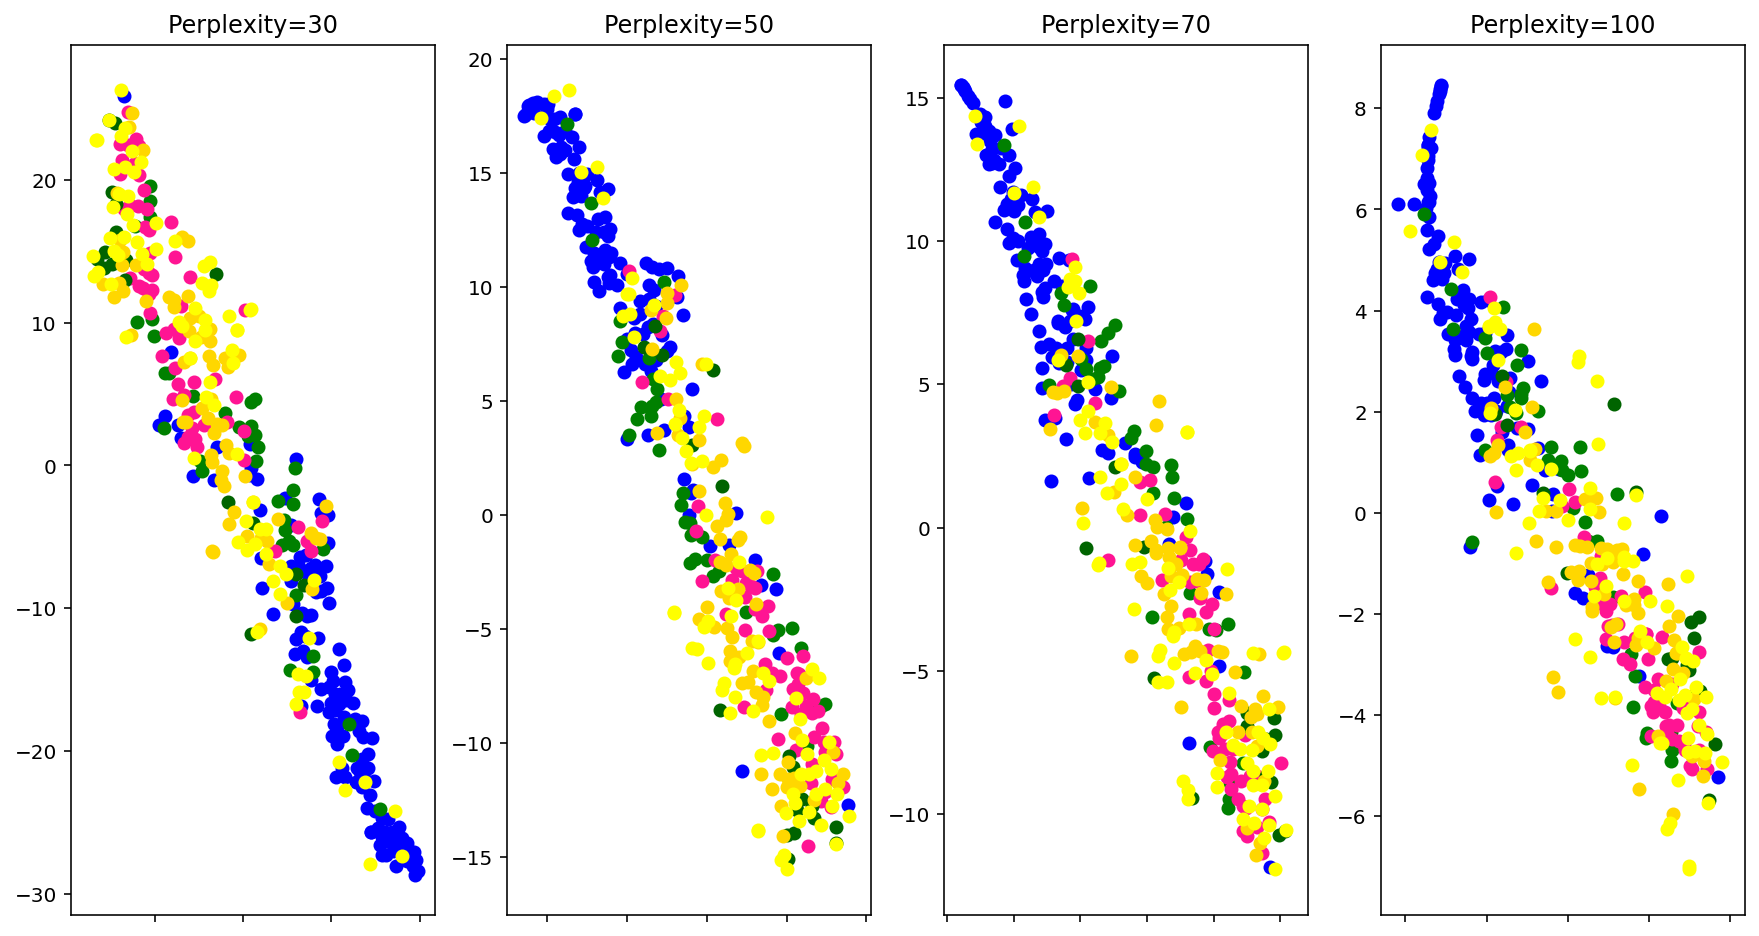

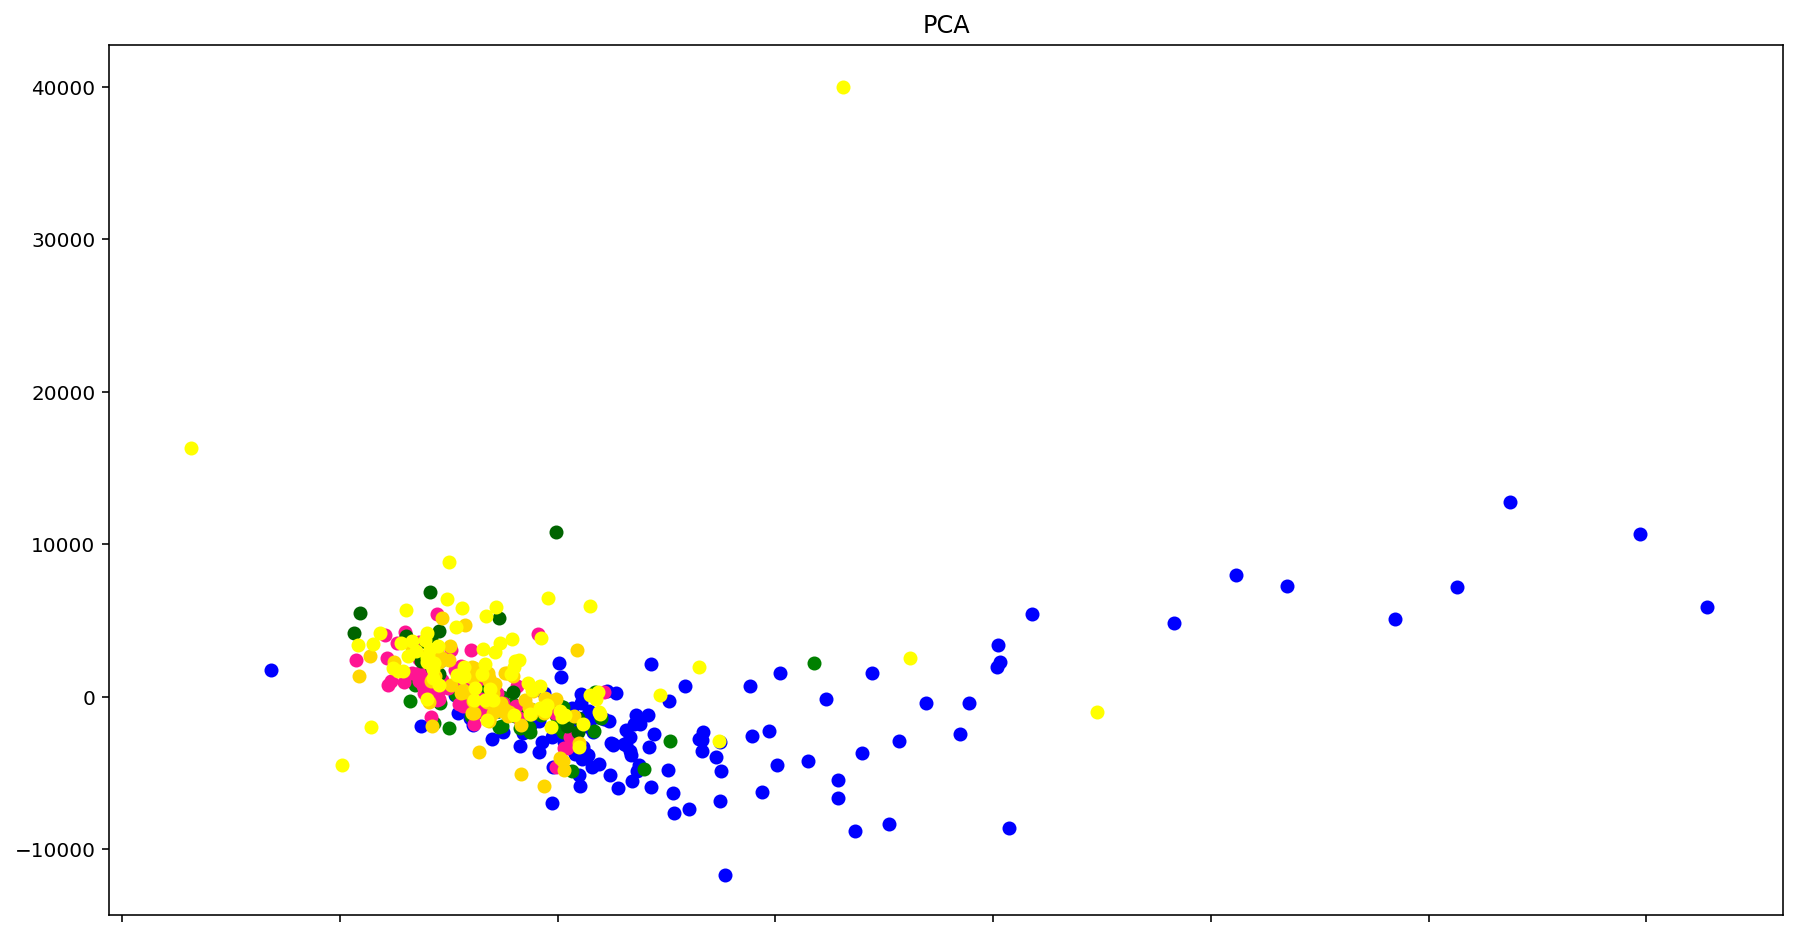

In [88]:
drawTSNE(X, 1)
draw_pca(X, 1)

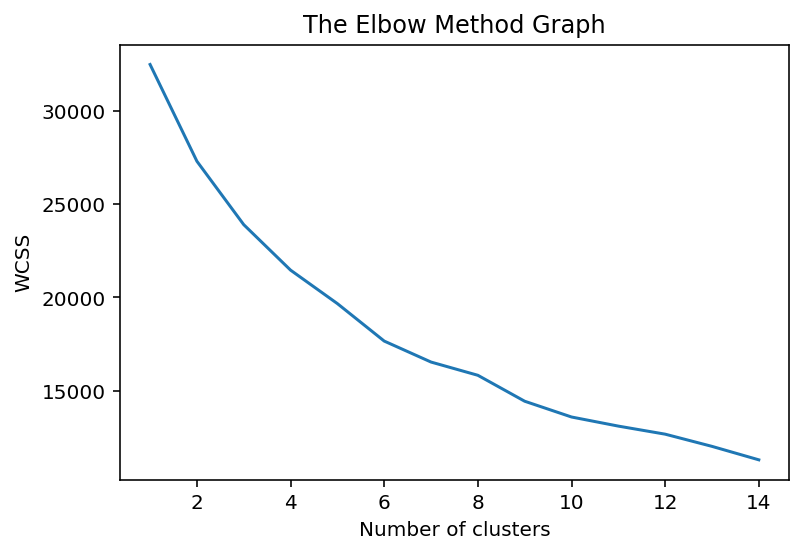

In [89]:
draw_clusters(X_scale, 15)

In [90]:
for n_clusters in range(10, 2, -1):
    kmeans, data=create_kmeans_clusters(X_scale, data, n_clusters, 0.2)

Number of clusters: 9 Silhouette Coefficient: 0.278 Calinski Harabaz Index: 58
Number of clusters: 8 Silhouette Coefficient: 0.237 Calinski Harabaz Index: 62
Number of clusters: 7 Silhouette Coefficient: 0.221 Calinski Harabaz Index: 59
Number of clusters: 6 Silhouette Coefficient: 0.208 Calinski Harabaz Index: 63
Number of clusters: 5 Silhouette Coefficient: 0.369 Calinski Harabaz Index: 62
Number of clusters: 4 Silhouette Coefficient: 0.367 Calinski Harabaz Index: 65
Number of clusters: 3 Silhouette Coefficient: 0.343 Calinski Harabaz Index: 68


In [91]:
kmeans, data=create_kmeans_clusters(X_scale, data, 6, 0.2)

Number of clusters: 6 Silhouette Coefficient: 0.208 Calinski Harabaz Index: 63


For n_clusters = 2 The average silhouette_score is : 0.20765369740960185
For n_clusters = 3 The average silhouette_score is : 0.24062373048211885
For n_clusters = 4 The average silhouette_score is : 0.23586233571804696
For n_clusters = 5 The average silhouette_score is : 0.2368224590735609
For n_clusters = 6 The average silhouette_score is : 0.16268139031567536
For n_clusters = 7 The average silhouette_score is : 0.15732487075130638
For n_clusters = 8 The average silhouette_score is : 0.16266683343513594
For n_clusters = 9 The average silhouette_score is : 0.18390475384529847
For n_clusters = 10 The average silhouette_score is : 0.13916151241139632
For n_clusters = 11 The average silhouette_score is : 0.16120659048115082
For n_clusters = 12 The average silhouette_score is : 0.13869013126910718


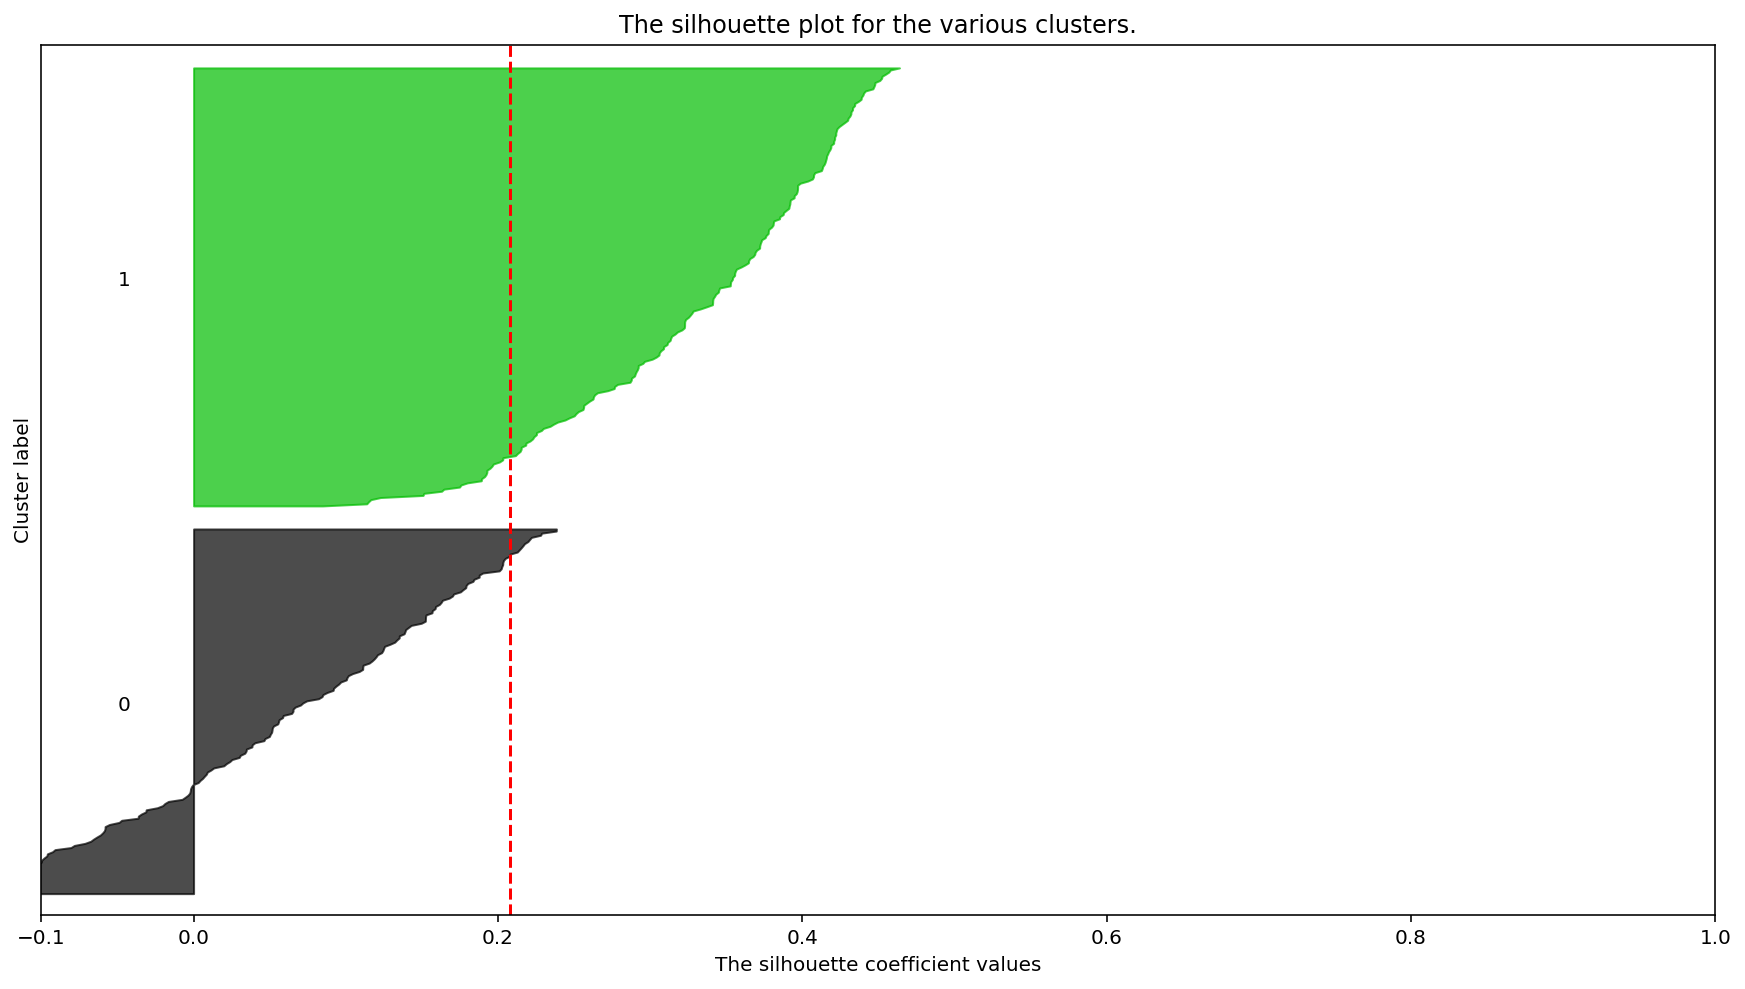

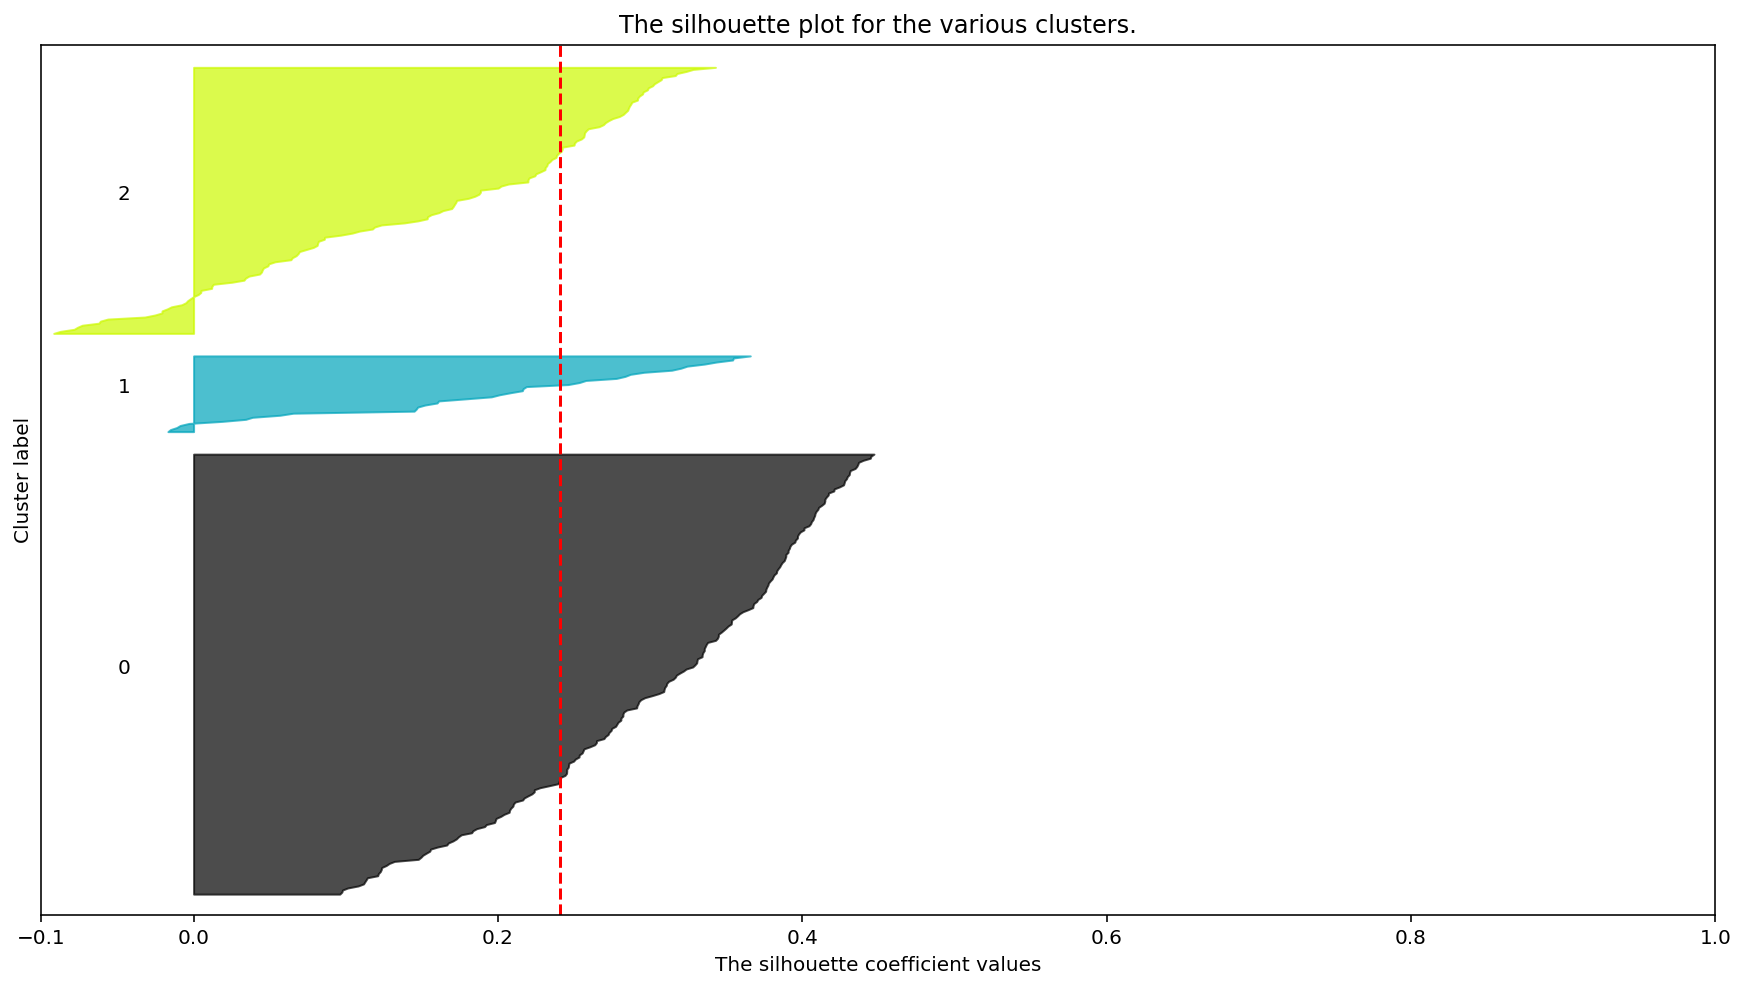

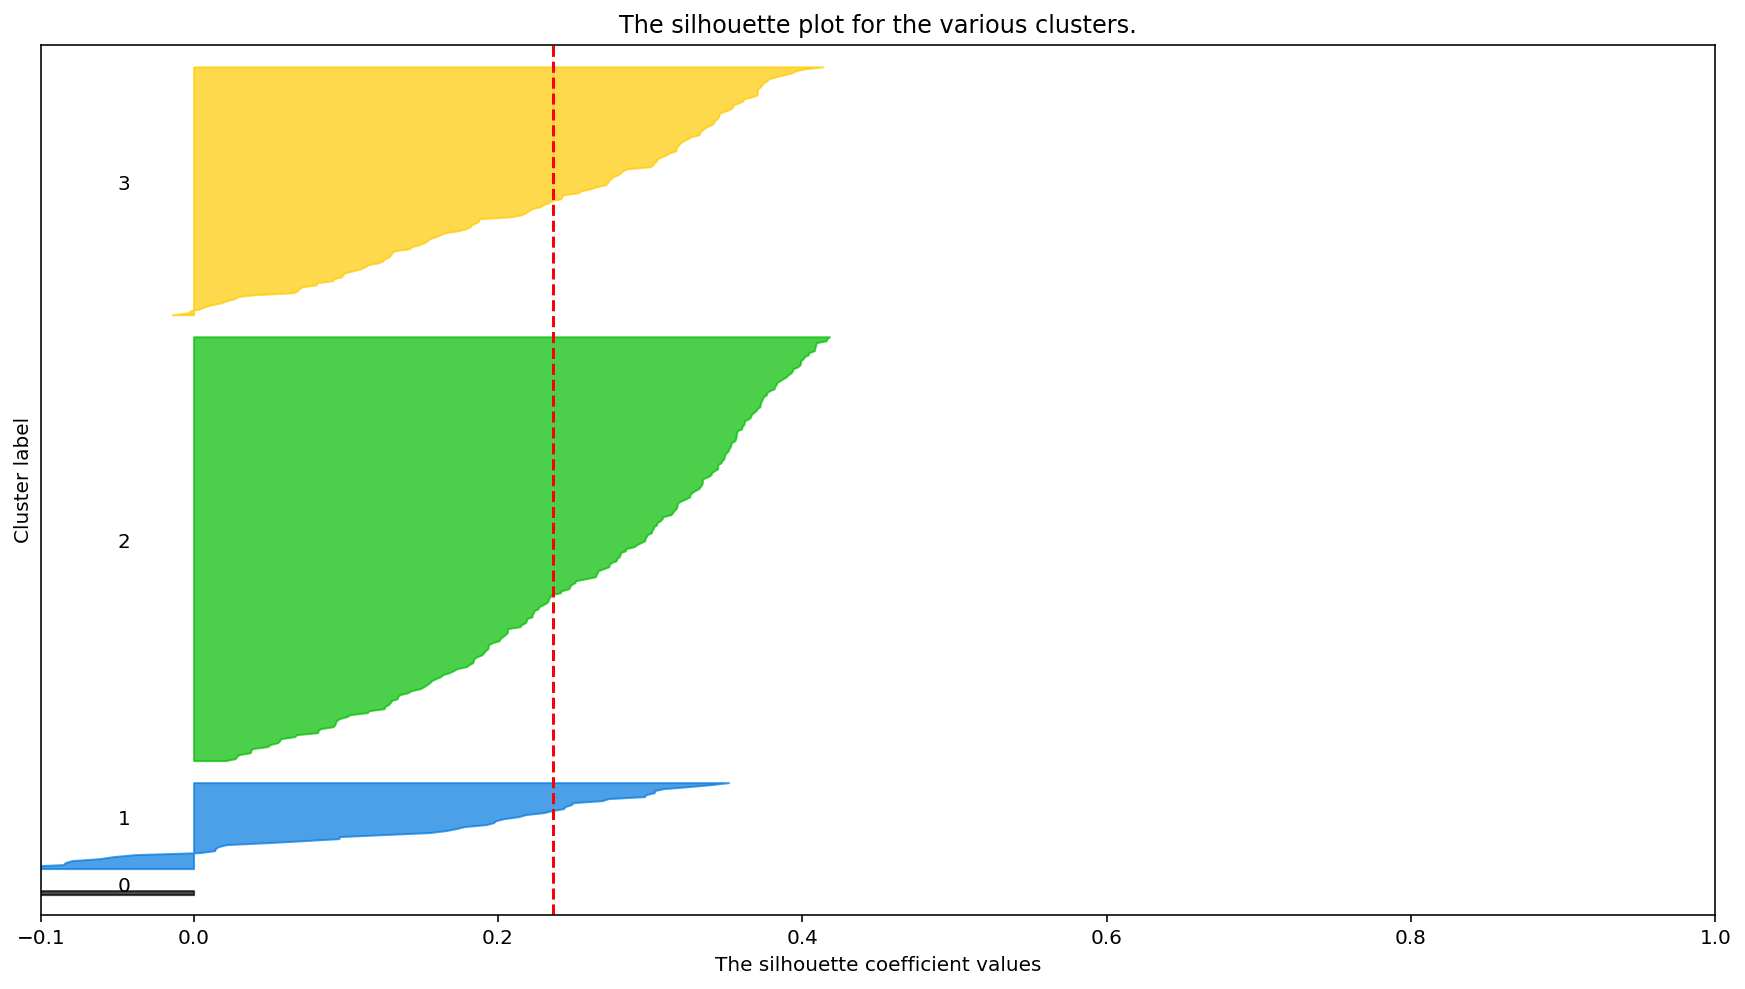

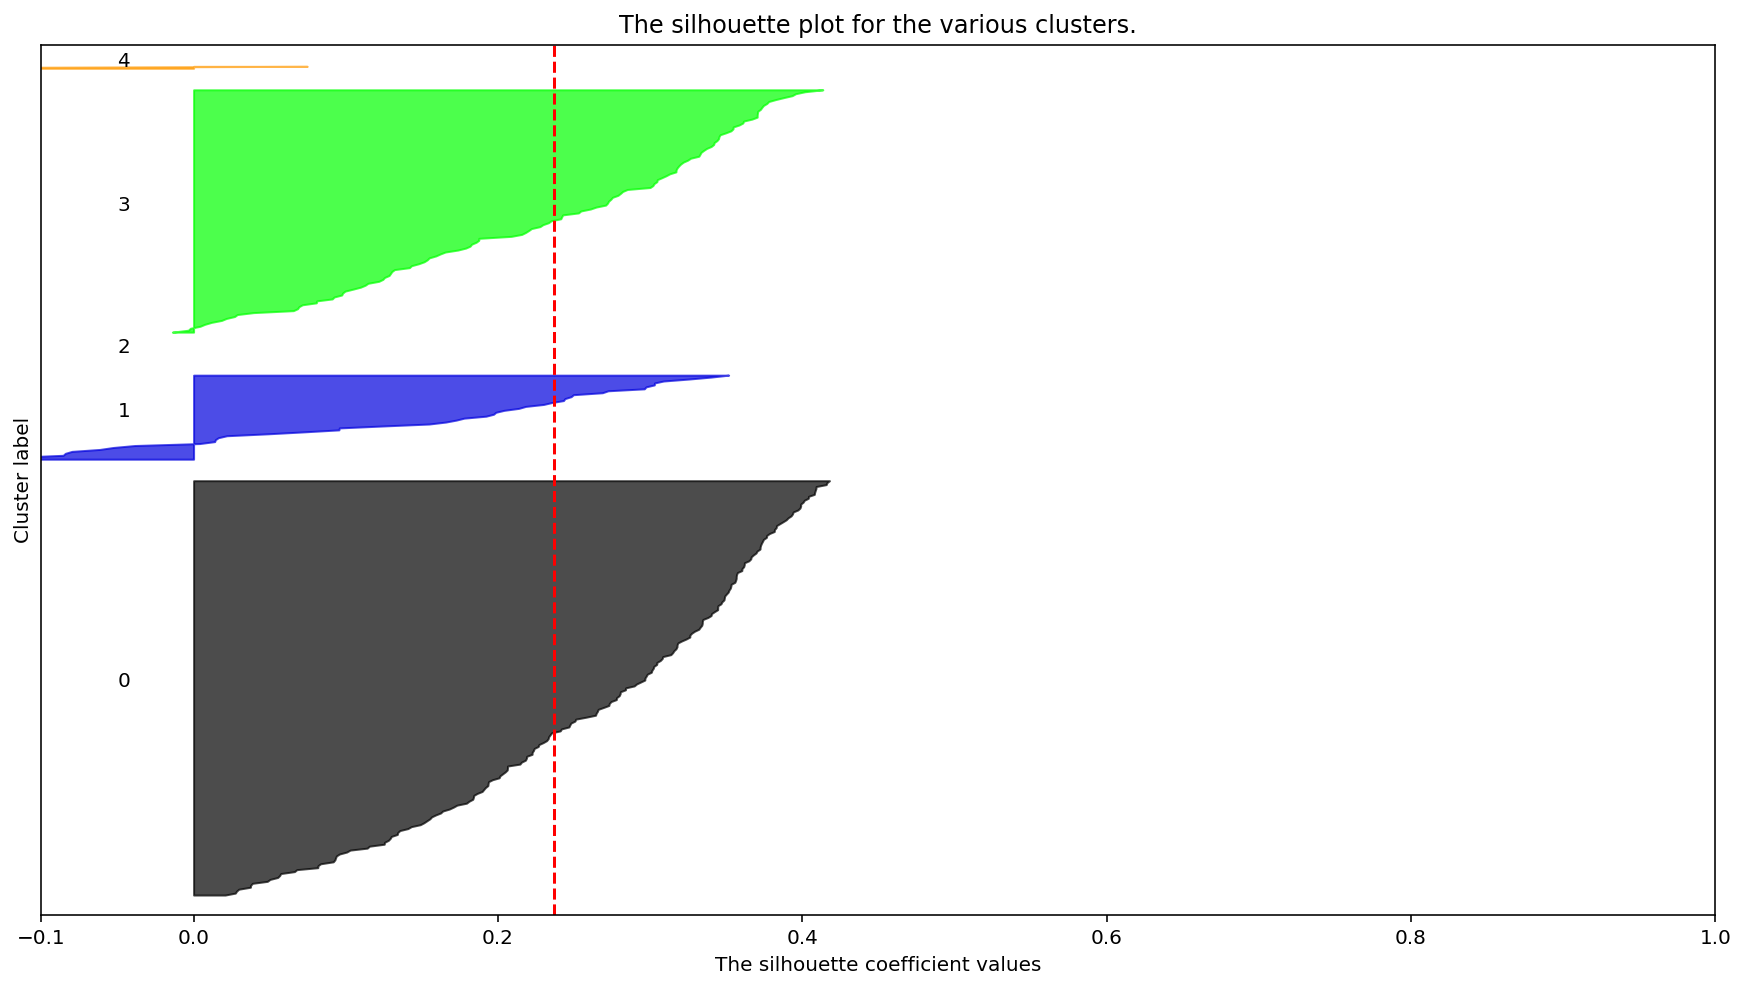

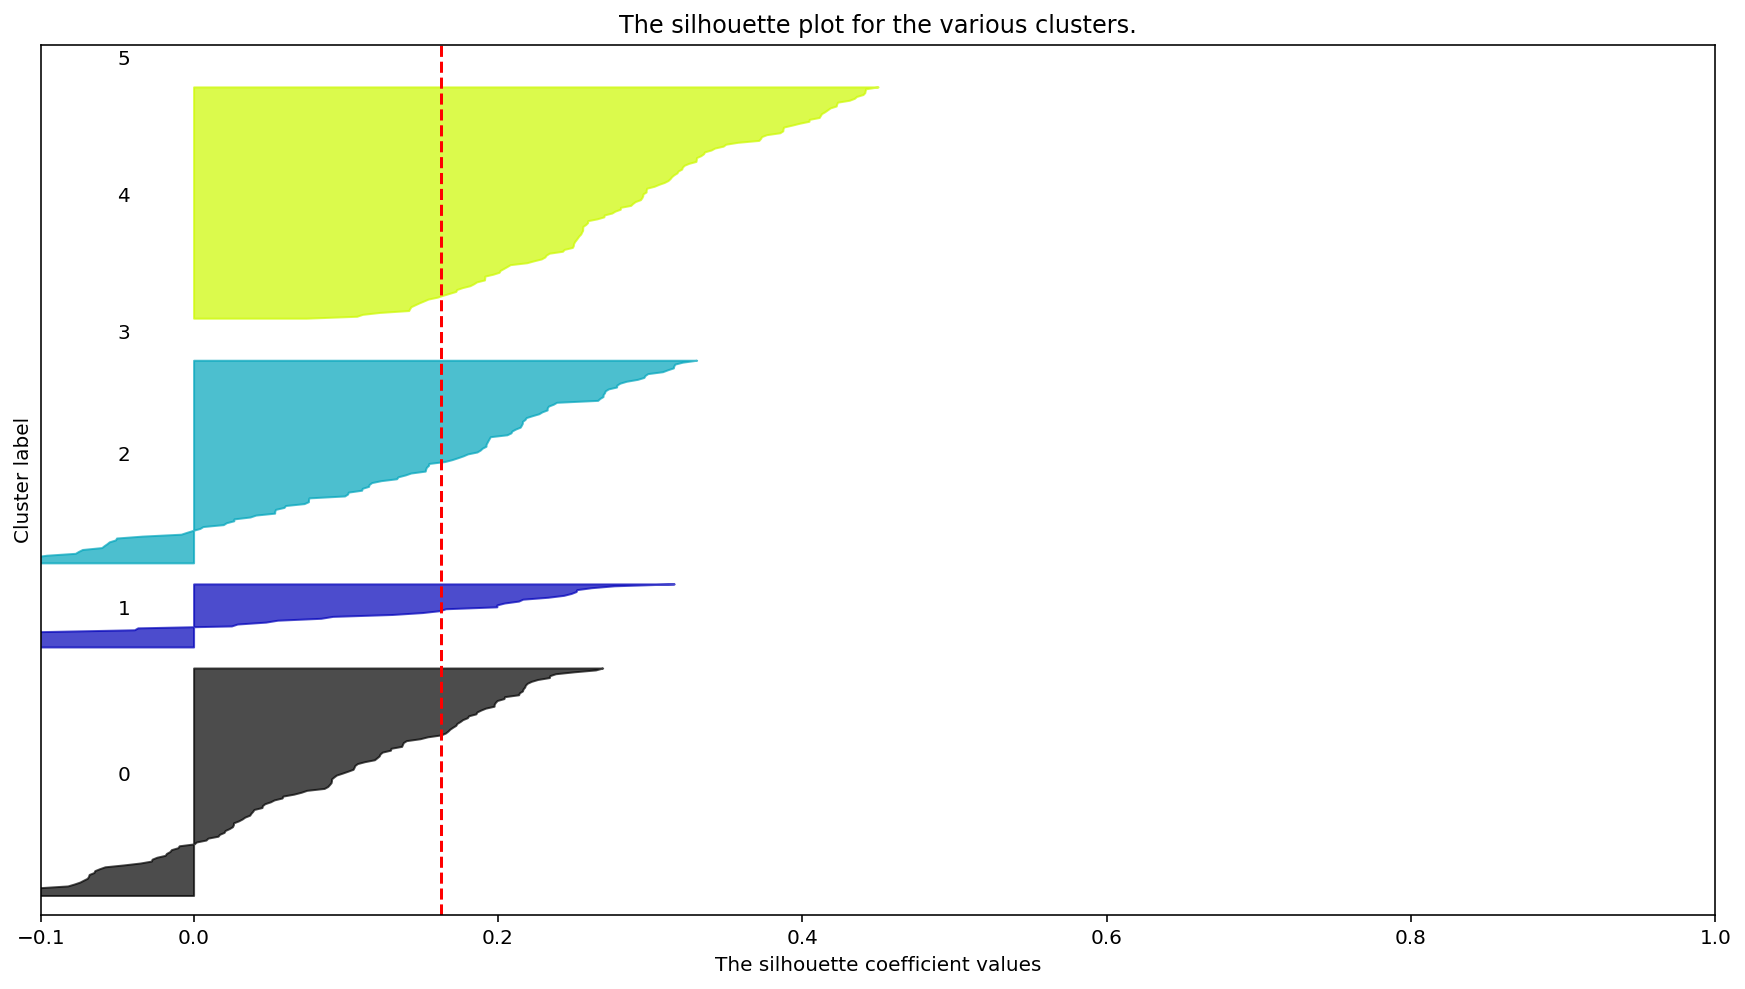

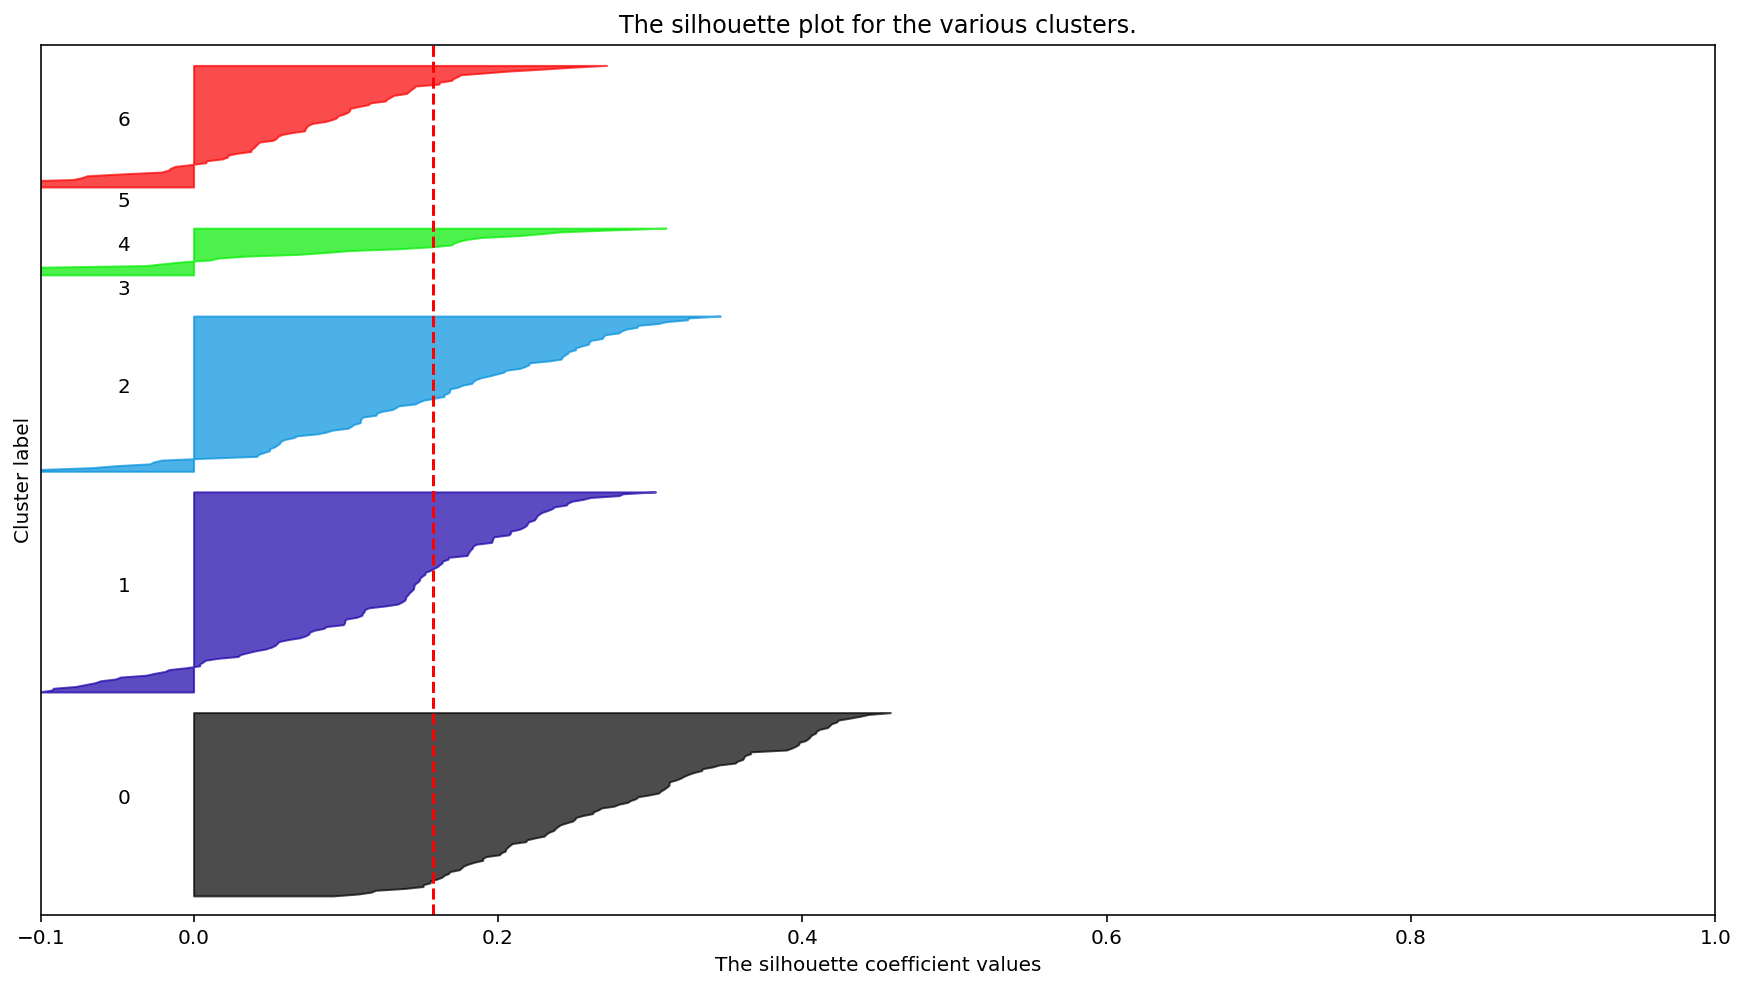

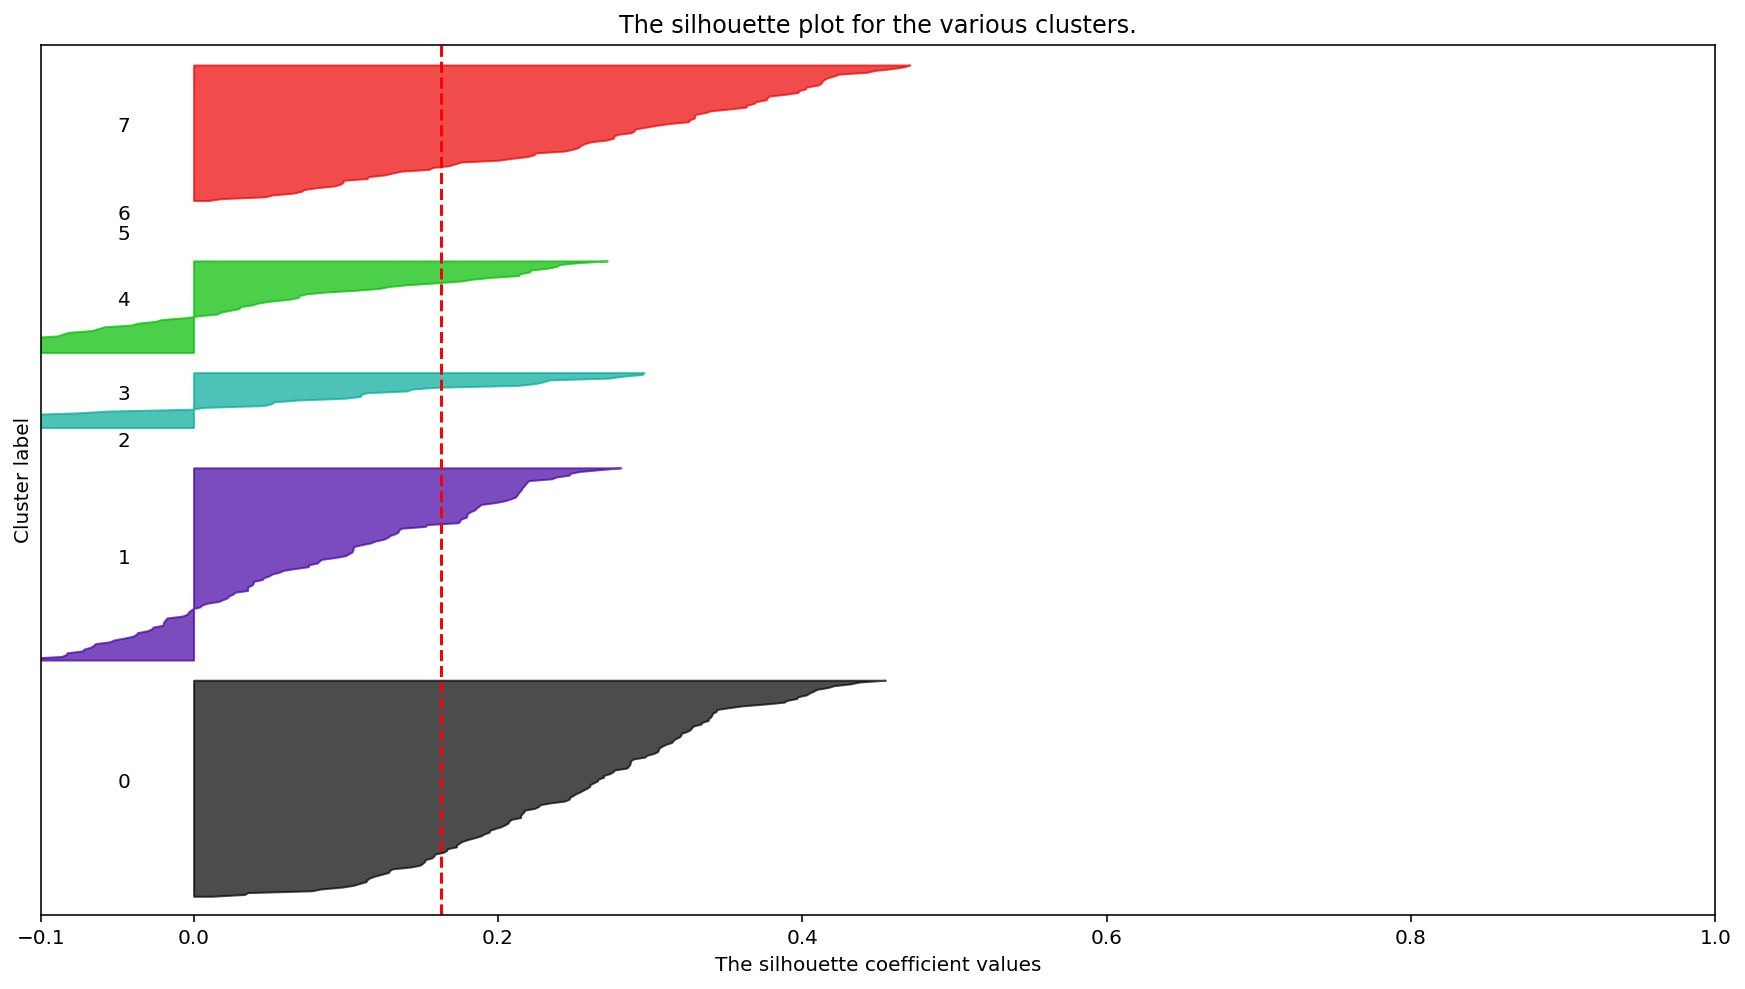

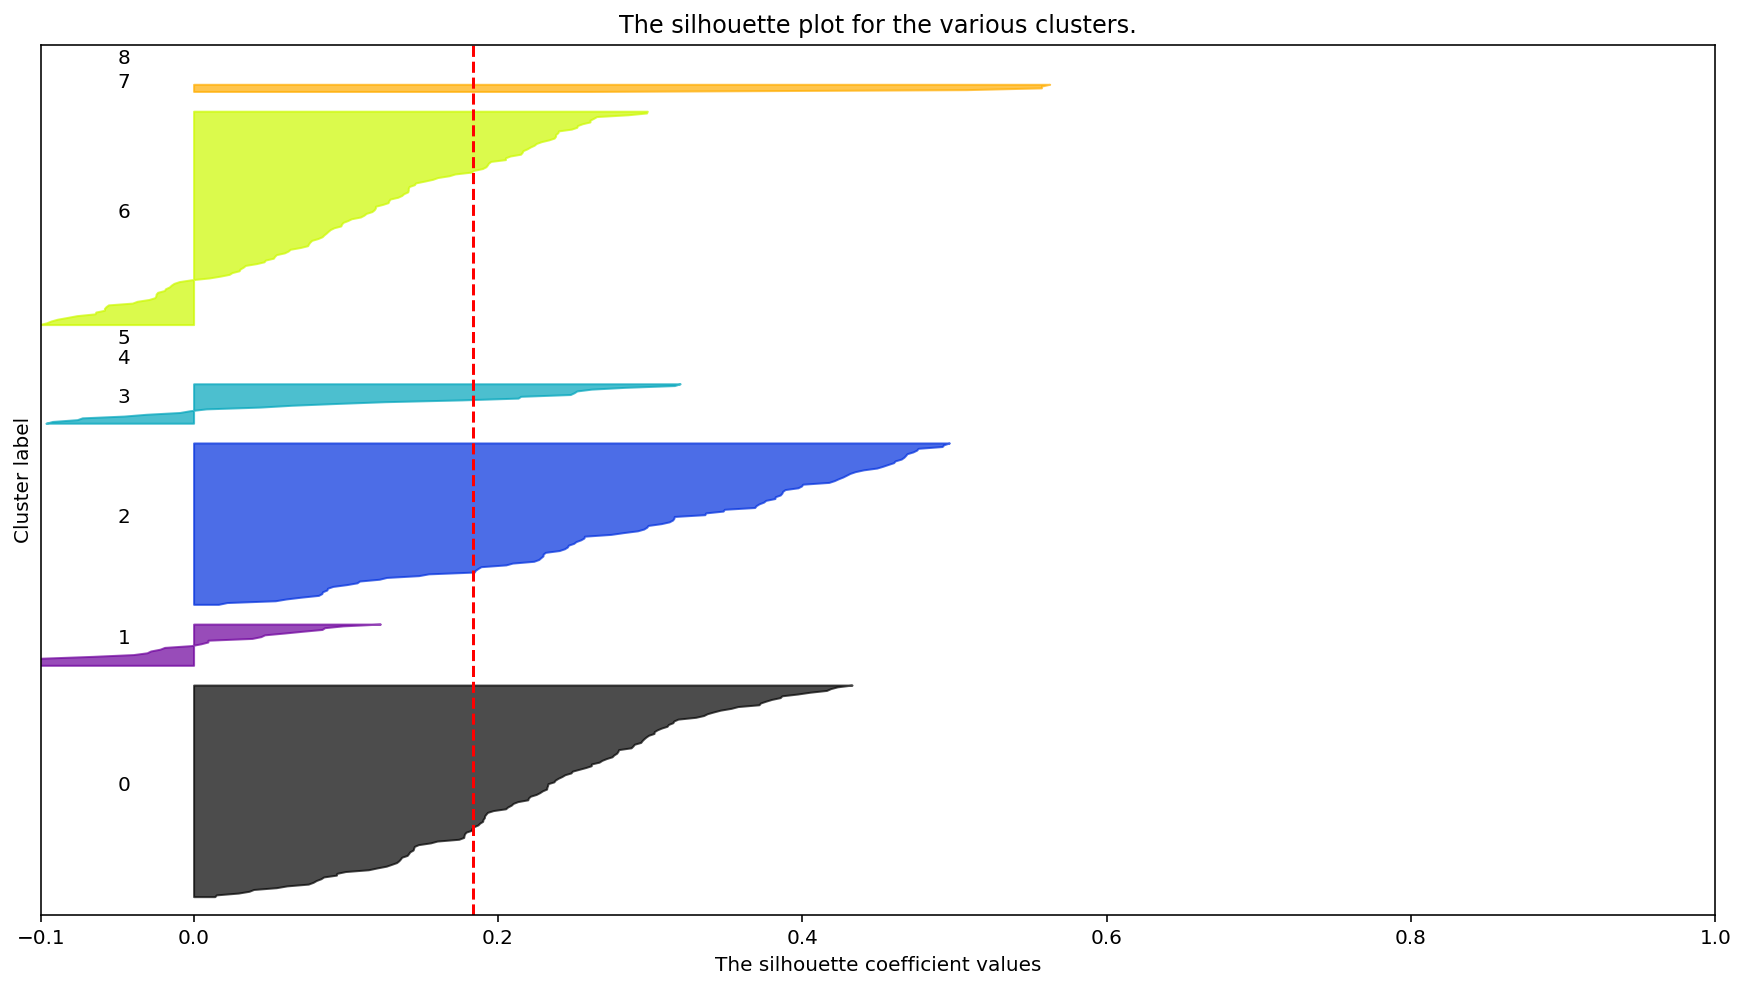

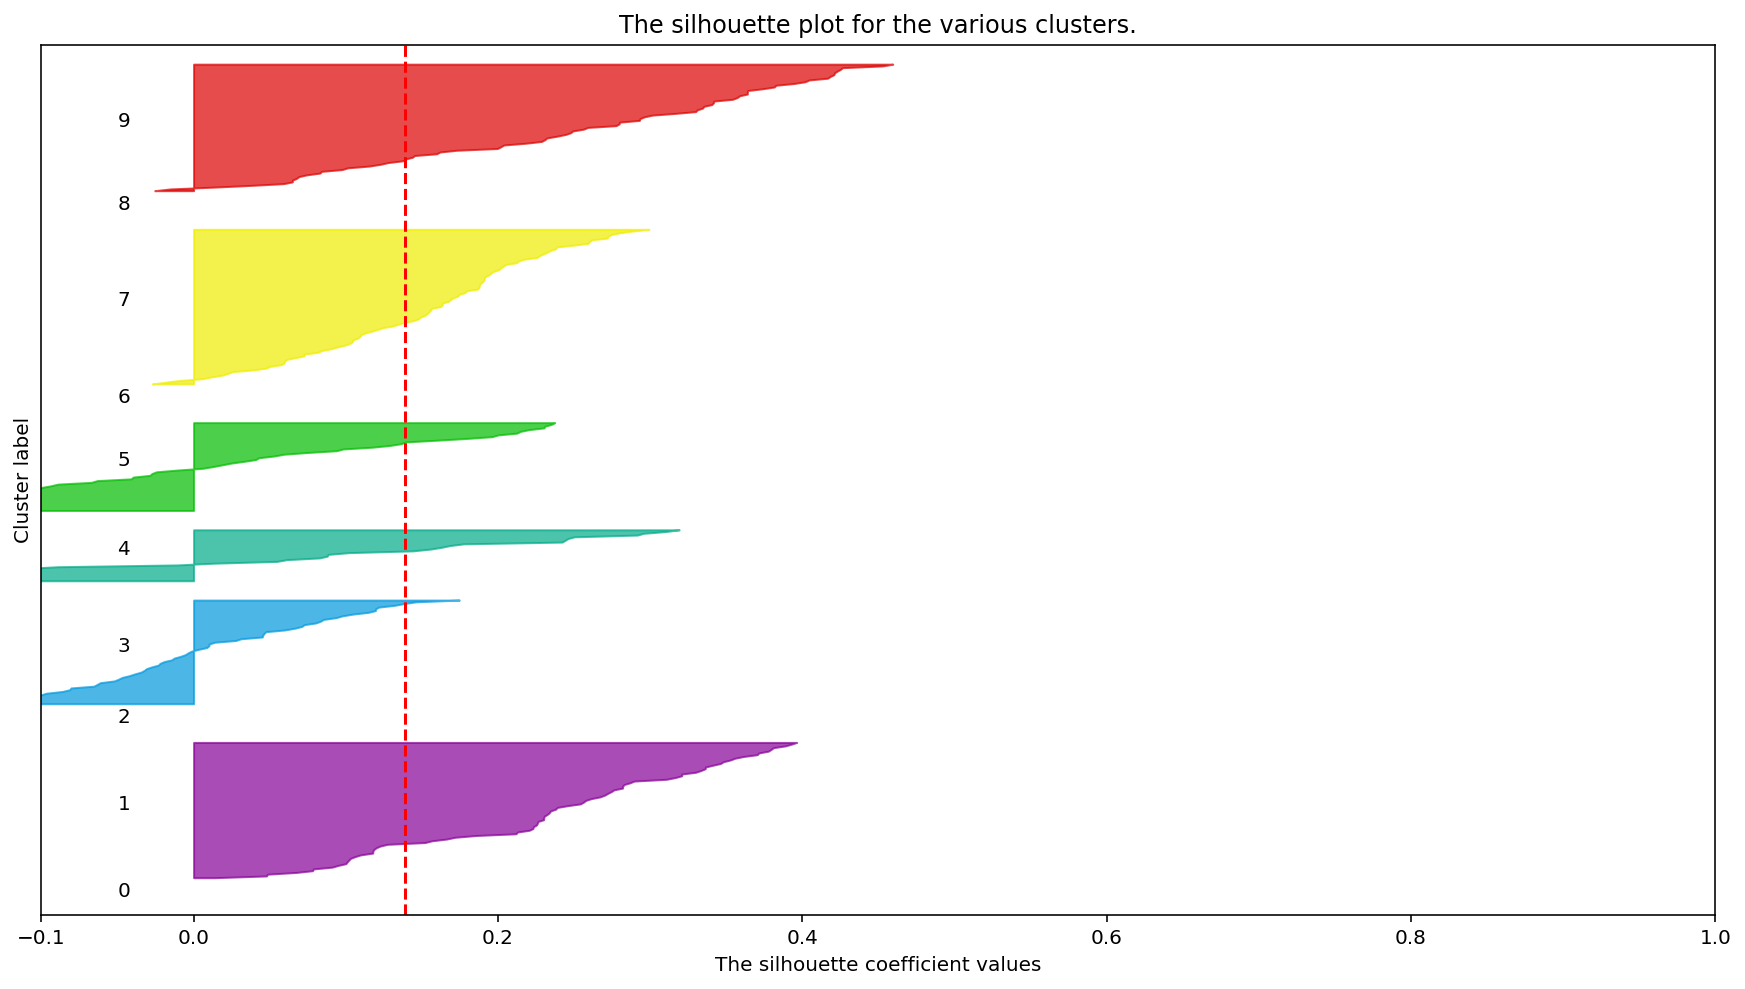

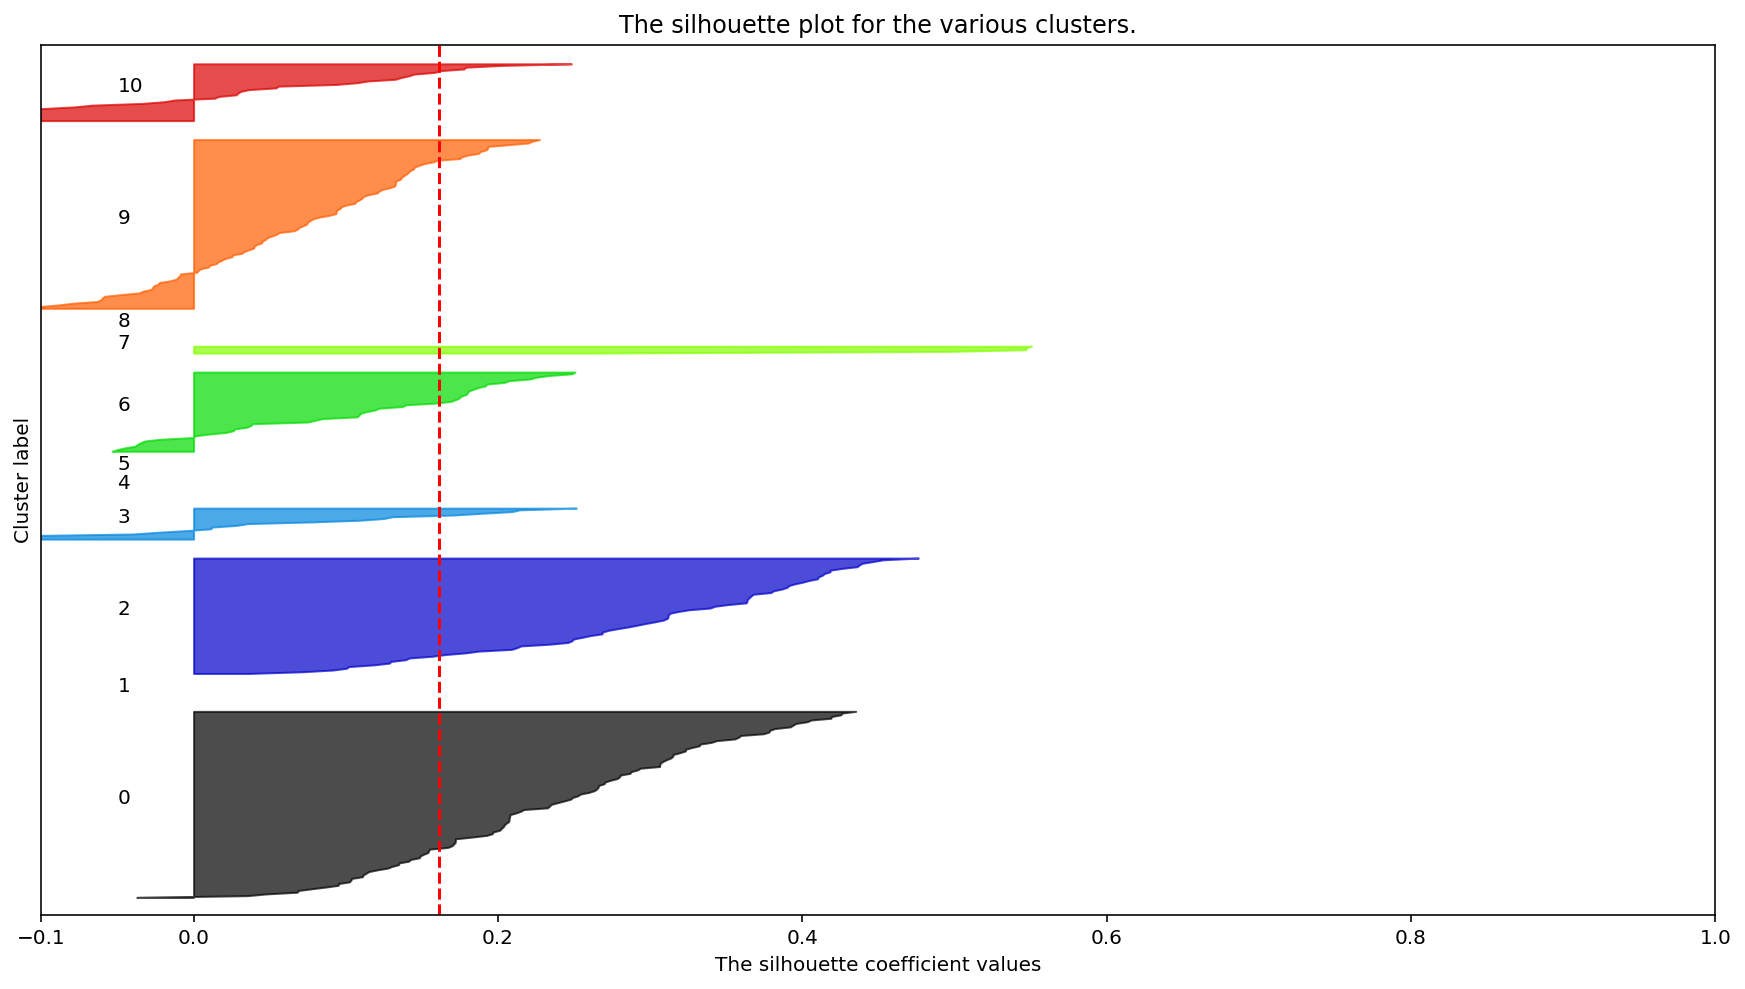

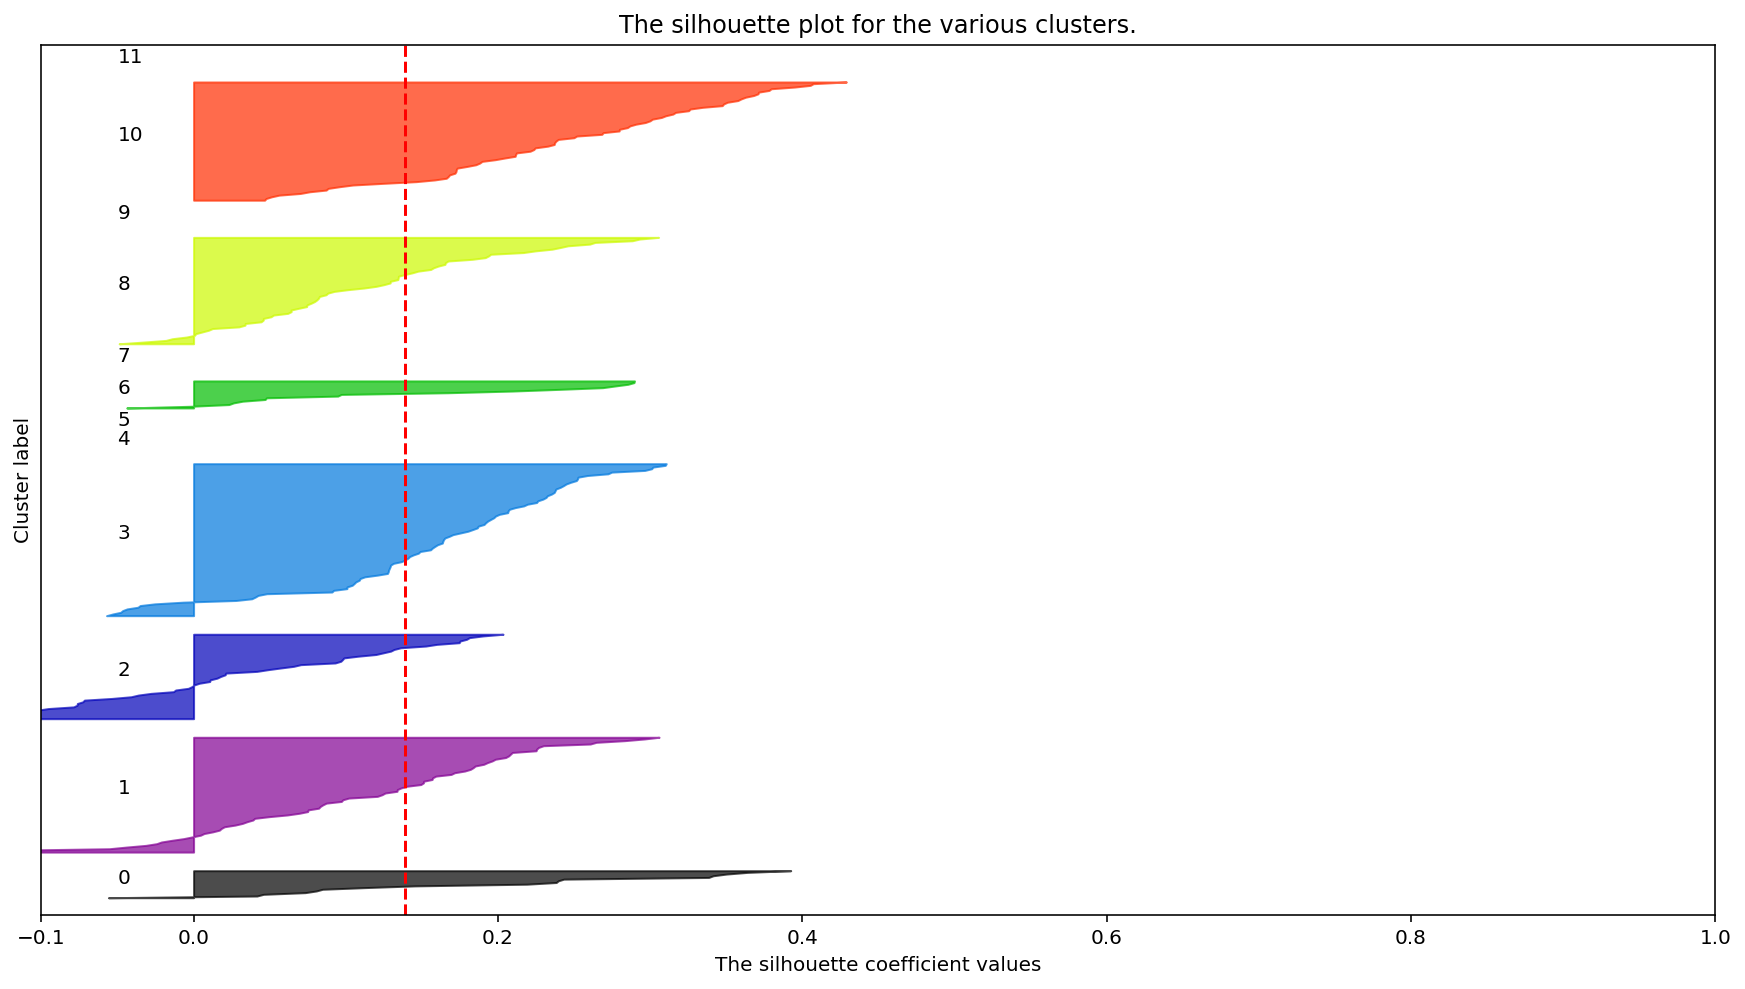

In [92]:
draw_silhouette_score(X_scale, kmeans)

Only specify one of 'column' or 'color'. Using 'color'.


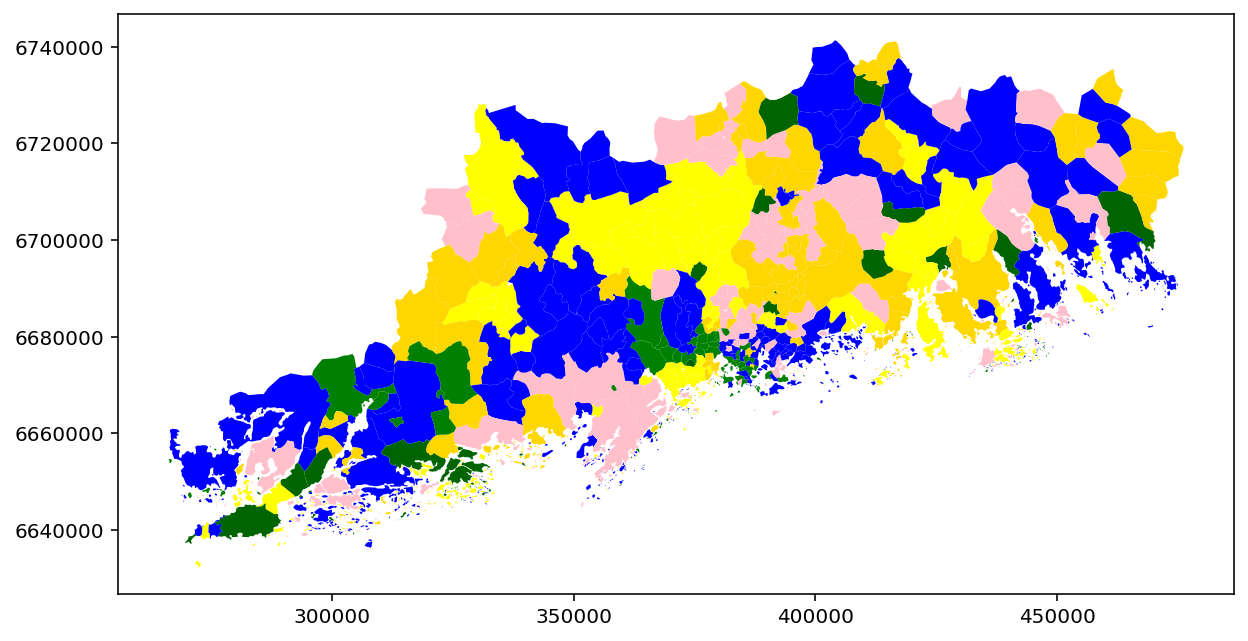

In [93]:
data.plot('Suurin_puolue numero', color = data['puoluevari'].to_list(), figsize=(10, 10))
plt.show()

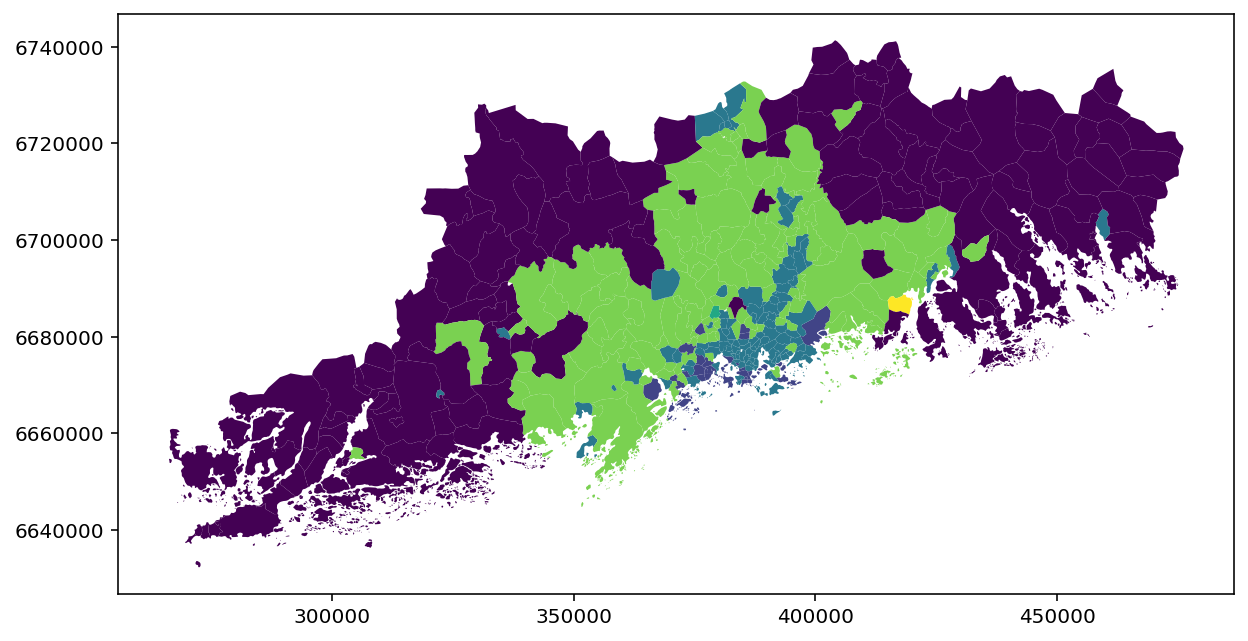

In [94]:
data.plot(column='cluster', figsize=(10, 10))
plt.show()

[0]	train-merror:0.69481	test-merror:0.64935
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 10 rounds.
Stopping. Best iteration:
[8]	train-merror:0.02273	test-merror:0.33766

testing
Start with xgb.cv params: merror: 0.28910433333333335
Best xgb.cv params: max_depth 4, min_child_weight 4, merror: 0.24059266666666668
Best xgb.cv params: gamma 0.0, merror: 0.24059266666666668
Best xgb.cv params: lambda 1.0, alpha 0.0, merror: 0.24059266666666668
Best xgb.cv params: colsample_bytree 0.6, subsample 1.0, merror: 0.23713433333333334
Best xgb.cv params: eta 0.2, merror: 0.27622300000000005
Found hyperparameters with 1 rounds 
{'objective': 'multi:softmax', 'num_class': 386, 'booster': 'gbtree', 'eval_metric': 'merror', 'max_depth': 4, 'min_child_weight': 4, 'gamma': 0.0, 'lambda': 1.0, 'alpha': 0.0, 'colsample_bytree': 0.6, 'subsample': 1.0, 'eta': 0.2}

[0]	train-merror:0.69481	test-merror:0.64935
Multip

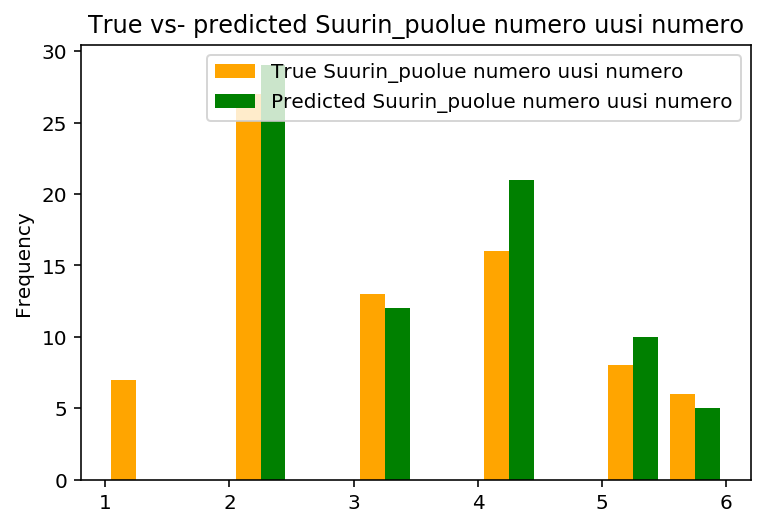

In [95]:
import xgboost as xgb
from sklearn.feature_selection import  mutual_info_classif

values = data.sort_values(by=['Suurin_puolue numero'])['Suurin_puolue numero'].unique()
j = 0
for i in values:
    j = j + 1
    data.loc[data['Suurin_puolue numero']==i, 'Suurin_puolue numero uusi numero'] = j

data.loc[:,'Suurin_puolue numero uusi numero'] = data['Suurin_puolue numero uusi numero'].astype(int) 
target = 'Suurin_puolue numero uusi numero'



#Check
#k_selected need to have correct values, if they are too large, evrything needs to be started again
k_selected = 'all'

test_size = 0.2

#Scalers attributes
kbest_score_func = mutual_info_classif
#set values to model configuration attributes

num_class = len(data['Suurin_puolue numero uusi numero']) + 1 #how many classes we are working with
col_mand = []
col_mand  = col_mandatory + ['Suurin_puolue numero uusi numero']
metric = 'merror'
Skfold=False
Verbose = False
testing=True

params = {
    # Parameters that we are going to tune.
    'objective':'multi:softmax',
    'num_class' : num_class,
    'booster' : 'gbtree',
    'eval_metric' : metric
} 


data, features_df, importance_df, model, params, dtest, X_train, y_train, X_test, y_test = create_prediction(data, target, kbest_score_func, metric, params, numeric_features, categorical_features)


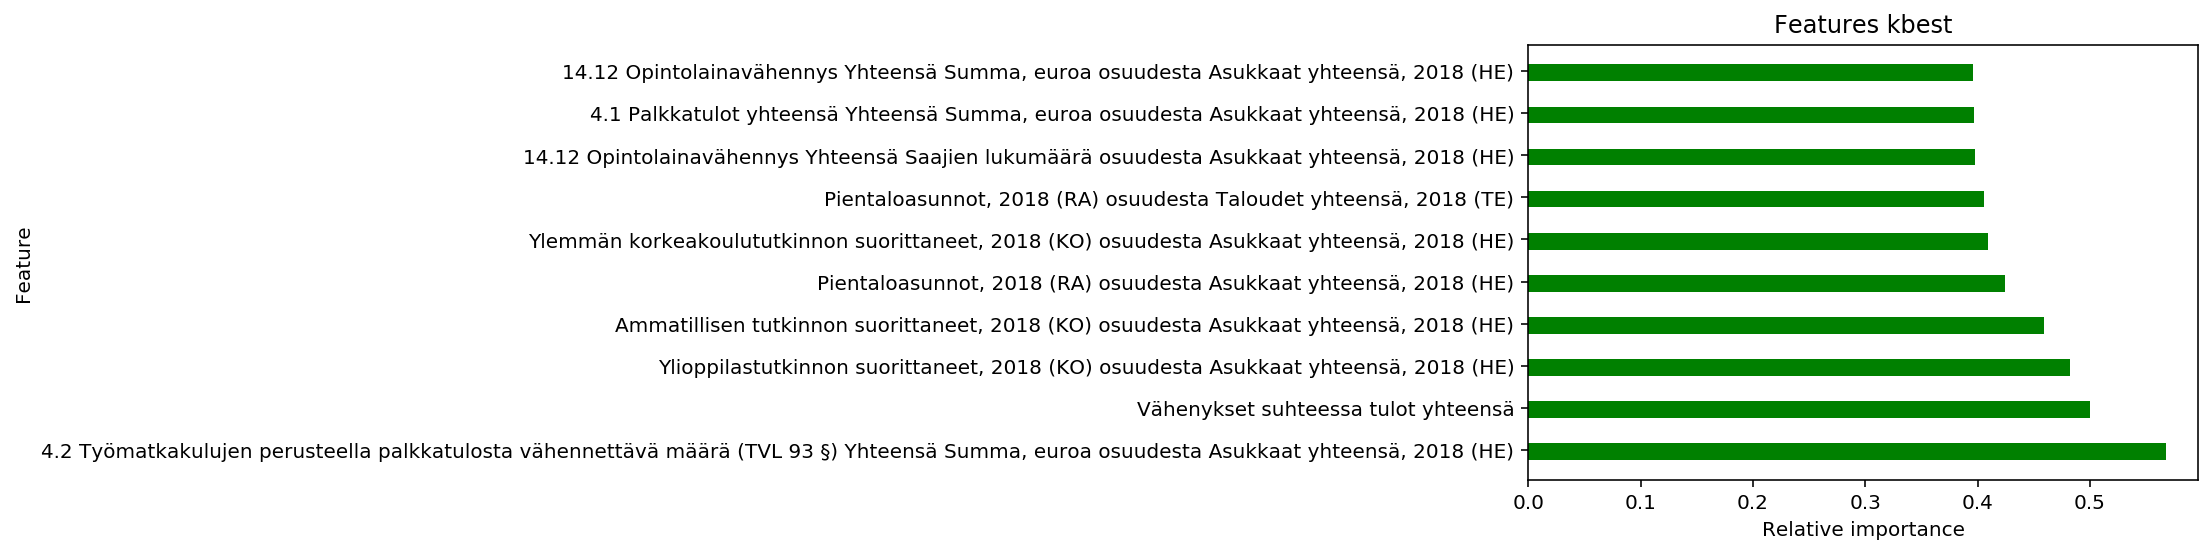

In [96]:
show_rows = 10
title = 'Features kbest'
draw_features(features_df[features_df['Selected']==True].head(show_rows)['Score'], features_df[features_df['Selected']==True].head(show_rows)['Column'], title)

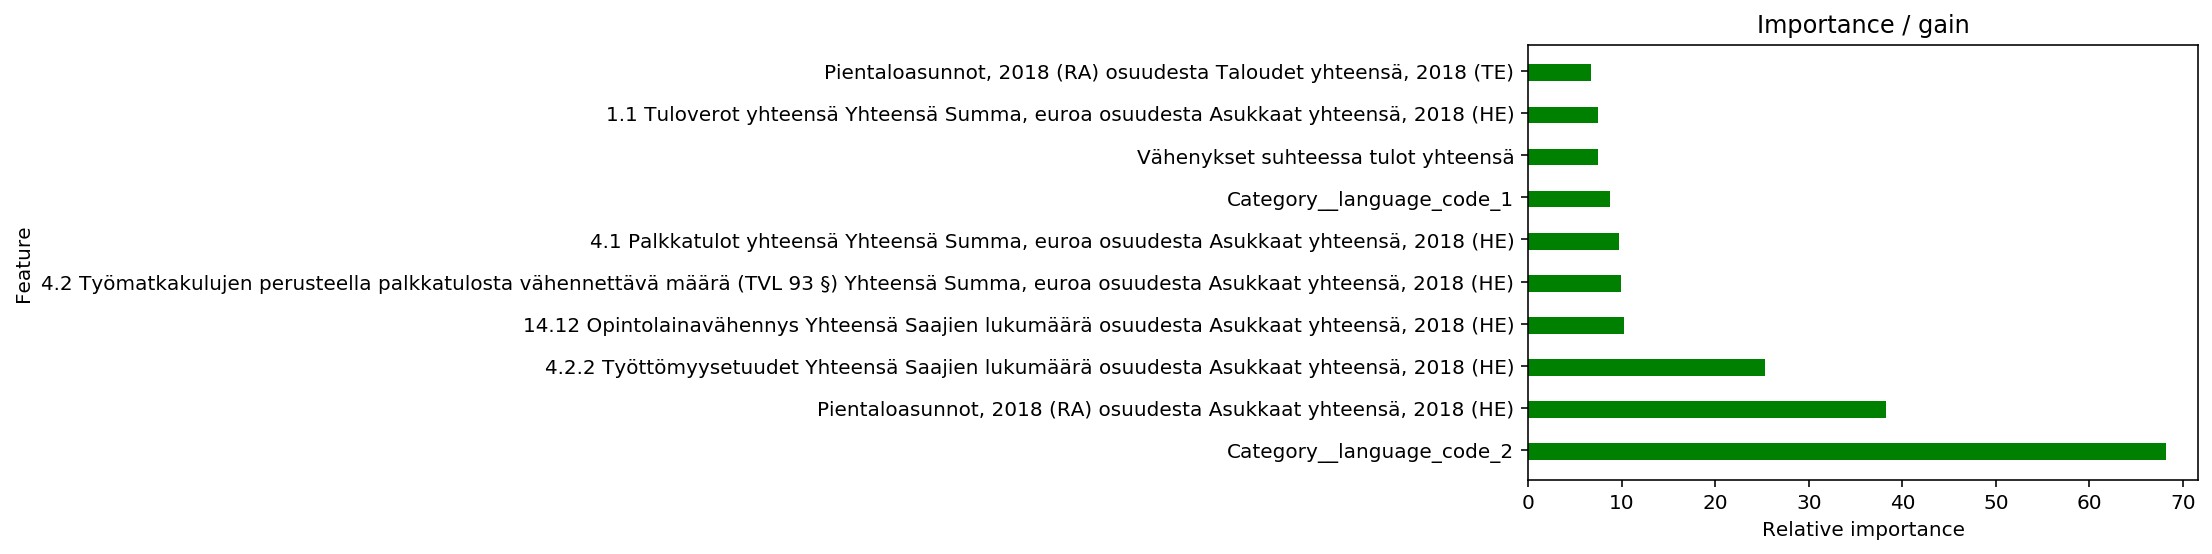

In [97]:
show_rows = 10
title = 'Importance / gain'
draw_features(importance_df[importance_df['Importance type']=='gain'].head(show_rows)['Score'], importance_df[importance_df['Importance type']=='gain'].head(show_rows)['Feature'], title)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


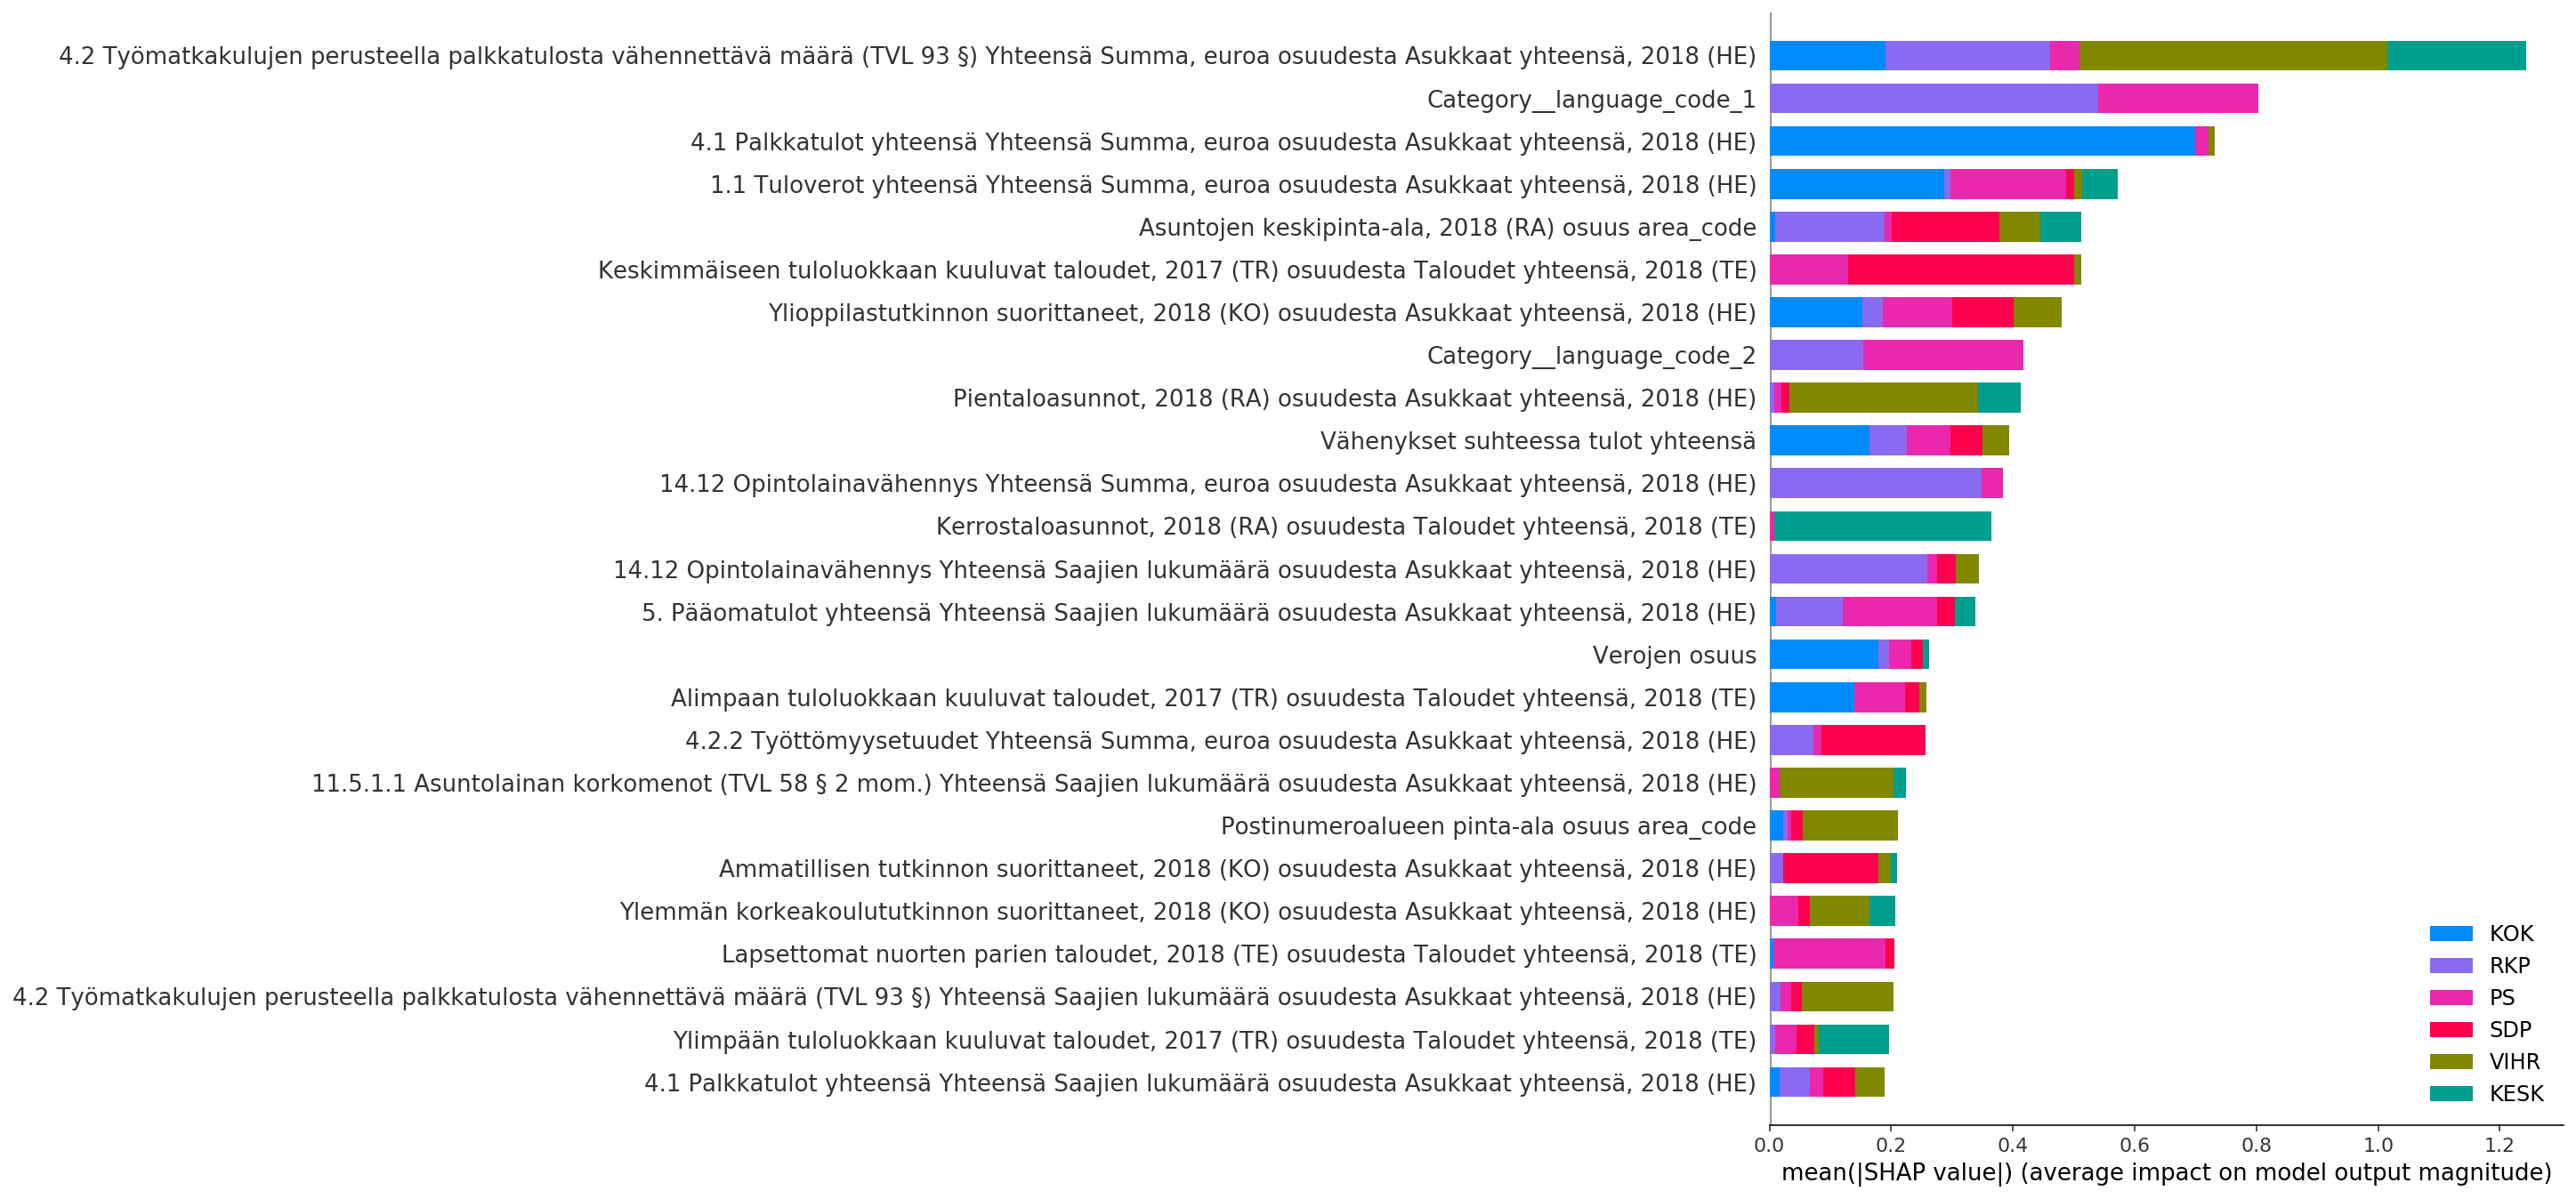

In [98]:
shap_suurin_puolue(data, X_train, y_train, params)

In [99]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from statsmodels.stats.proportion import proportion_confint


y_pred = model.predict(dtest)
lower, upper = proportion_confint(accuracy_score(y_test, y_pred) * len(y_test), len(y_test), 0.05)
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: ", f1_score(y_test, y_pred, average="macro"))
print("Precision Score: ", precision_score(y_test, y_pred, average="macro", zero_division=0))
print("Recall Score: ", recall_score(y_test, y_pred, average="macro"))
print('Confidence level lower=%.3f, upper=%.3f' % (lower, upper))

Accuracy: 0.7532467532467533
F1 Score:  0.6133458133458133
Precision Score:  0.5958675424192666
Recall Score:  0.6409366096866097
Confidence level lower=0.657, upper=0.850


In [100]:
party=data.groupby('Suurin_puolue',as_index=False ).mean()[['Suurin_puolue', 'Suurin_puolue numero','Suurin_puolue numero uusi numero']]
party.loc[:,'Suurin_puolue numero uusi numero'] = party['Suurin_puolue numero uusi numero'].astype(int) 

def get_puolue_nimi(data):
    val = party[party['Suurin_puolue numero uusi numero']==data]['Suurin_puolue'].unique().item()
    return (val)

def get_puolue_numero(data):
    val = party[party['Suurin_puolue numero uusi numero']==data]['Suurin_puolue numero'].unique().item()
    return (val)

data.loc[:, 'Ennustettu_Suurin_puolue nimi']= data['Ennustettu_Suurin_puolue numero uusi numero'].apply(get_puolue_nimi)

data.loc[:, 'Ennustettu_Suurin_puolue numero']= data['Ennustettu_Suurin_puolue numero uusi numero'].apply(get_puolue_numero)
    

Only specify one of 'column' or 'color'. Using 'color'.


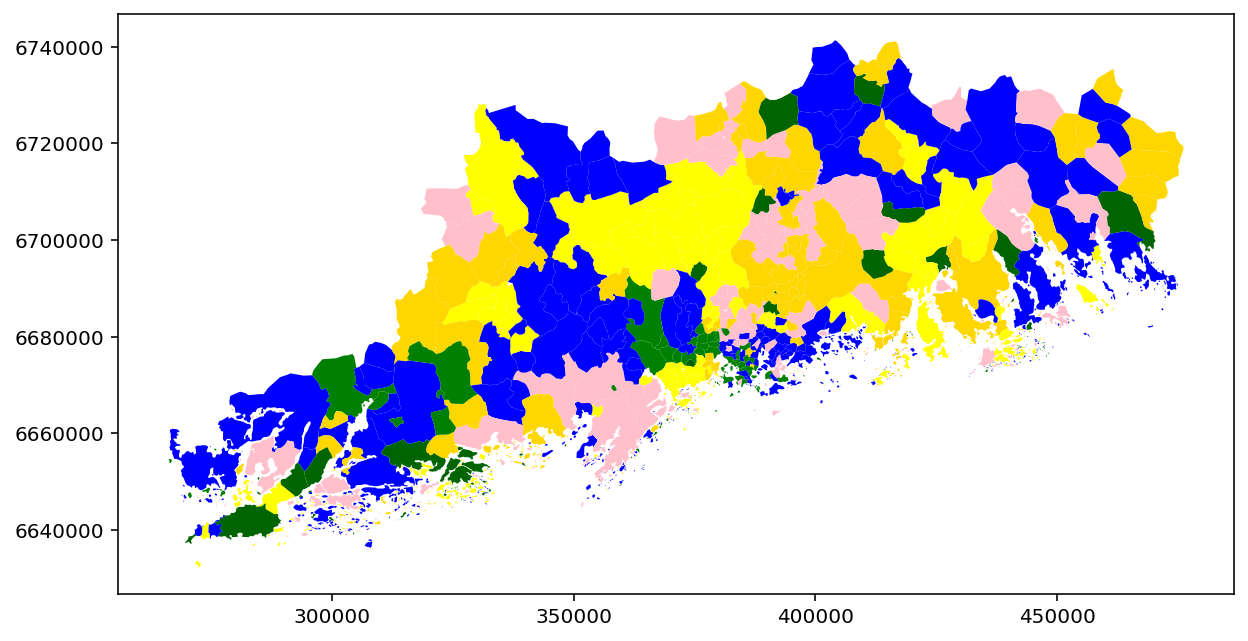

In [101]:
import geopandas as gp
data = gp.GeoDataFrame(data, geometry='geometry')
data.plot('Ennustettu_Suurin_puolue numero', color = data['puoluevari'].to_list(), figsize=(10, 10))
plt.show()

[0]	train-rmse:582.54169	test-rmse:794.73822
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[22]	train-rmse:13.19229	test-rmse:595.37775

testing
Start with xgb.cv params: rmse: 393.77415999999994
Best xgb.cv params: max_depth 4, min_child_weight 1, rmse: 373.641144
Best xgb.cv params: gamma 0.0, rmse: 373.641144
Best xgb.cv params: lambda 1.0, alpha 0.8, rmse: 373.0278523333333
Best xgb.cv params: colsample_bytree 1.0, subsample 1.0, rmse: 373.0278523333333
Best xgb.cv params: eta 0.4, rmse: 379.48369366666674
Best xgb.cv params: scale_pos_weight 0.0, rmse: 379.48369366666674
Found hyperparameters with 1 rounds 
{'objective': 'reg:squarederror', 'booster': 'gbtree', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 1, 'gamma': 0.0, 'lambda': 1.0, 'alpha': 0.8, 'colsample_bytree': 1.0, 'subsample': 1.0, 'eta': 0.4, 'scale_pos_weight': 0.0}

[0]	train-rmse:5

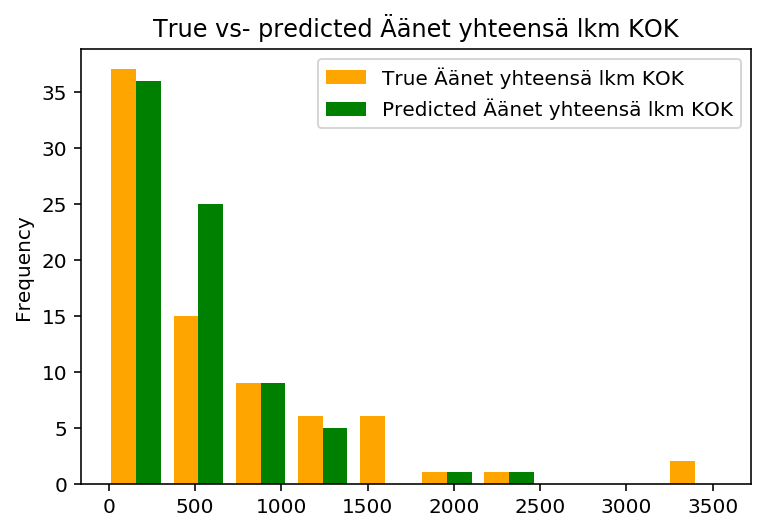

In [102]:
import xgboost as xgb
from sklearn.feature_selection import mutual_info_regression

puolue = 'KOK'
target = 'Äänet yhteensä lkm ' + puolue

ennustettu_puolue = 'Ennustettu_Äänet yhteensä lkm ' + puolue

#set values to feature engineering attributes

#Check
#k_selected need to have correct values, if they are too large, evrything needs to be started again
k_selected = 'all'

test_size = 0.2

#Scalers attributes
kbest_score_func = mutual_info_regression 


metric = 'rmse'
Skfold=False
Verbose = False
testing=True

params = {
    #Initial xgboost parameters to be automatically tuned
    'objective':'reg:squarederror',
    'booster' : 'gbtree',
    'eval_metric' : metric
    } 





data, features_df, importance_df, model, params, dtest, X_train, y_train, X_test, y_test = create_prediction(data, target, kbest_score_func, metric, params, numeric_features, categorical_features)


In [103]:
laskennallinen = data[target].sum()
ennuste = data[ennustettu_puolue].sum()
aitotulos = selected_vaalidata[selected_vaalidata['Puolueen nimilyhenne suomeksi']==puolue].sum()['Äänet yhteensä lkm']
print('Laskennallisen virhe aitoon tulokseen', (aitotulos - laskennallinen)/aitotulos)
print('Ennusteen virhe aitoon tulokseen', (aitotulos - ennuste)/aitotulos)
print('Ennusteen virhe laskennalliseen tulokseen', (laskennallinen - ennuste)/laskennallinen)
aanet=selected.columns[selected.columns.str.startswith('Äänet yhteensä lkm')]
print('Ennusteen mukainen ääniosuus', ennuste/selected_vaalidata[selected_vaalidata['Puolueen nimilyhenne suomeksi']=='Äänet']['Äänet yhteensä lkm'].sum())
aaniosuus = selected_vaalidata[selected_vaalidata['Puolueen nimilyhenne suomeksi']==puolue].sum()['Äänet yhteensä lkm']/selected_vaalidata[selected_vaalidata['Puolueen nimilyhenne suomeksi']=='Äänet']['Äänet yhteensä lkm'].sum()
print('Vaalien mukainen ääniosuus', aaniosuus)
print('Ennusteessa mukana olevat postinumerot', data['Postinumero'].count()/post_included)

Laskennallisen virhe aitoon tulokseen 0.020586337607871603
Ennusteen virhe aitoon tulokseen 0.07724909455903702
Ennusteen virhe laskennalliseen tulokseen 0.05785375386001029
Ennusteen mukainen ääniosuus 0.1951544961413444
Vaalien mukainen ääniosuus 0.21149206680873883


TypeError: unsupported operand type(s) for /: 'int' and 'str'

In [ ]:
k2  = shap_values(X_train, y_train, params)

colorlist = k2['Sign']
ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP Value (Red = Positive Impact)")
plt.show()

In [ ]:
k2.tail(30)

In [ ]:
show_rows = 10
title = 'Features kbest'
draw_features(features_df[features_df['Selected']==True].head(show_rows)['Score'], features_df[features_df['Selected']==True].head(show_rows)['Column'], title)

In [ ]:

title = 'Importance / gain'
draw_features(importance_df[importance_df['Importance type']=='gain'].head(show_rows)['Score'], importance_df[importance_df['Importance type']=='gain'].head(show_rows)['Feature'], title)

In [ ]:
data.plot(column=target, figsize=(10, 10))
plt.show()

In [ ]:
from xgboost import plot_tree
plot_tree(model, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.show()